In [1]:
import os
import pandas as pd
import numpy as np
import sys
from collections import OrderedDict
from IPython.display import display
import matplotlib.pyplot as plt
from numba import jit, prange, njit, config

sys.setrecursionlimit(100000)

from numba.typed import Dict, List

from scripts import test_mutation, calculate_all_fitnesses, calculate_fitness, genotype_hash,deep_copy_genotype, mutate_genotype_inplace, assert_equality_of_hashes
from scripts import random_int, NODE_TYPE, GENOTYPE_TYPE, best_n_items, create_full_tree_from_genome, seed
from scripts import create_n_genotypes, crossover_numba, selection_tournament
from tqdm.notebook import tqdm

#load_and_print_csvs_from_folders()
#test_n_creation()


# TODO

* Parametrizar o tamanho da seleção com lexicase
* Criar função de rodar experimentos para arquivo
* Extrair as funções do arquivo scripts.py
* Falar da implentação de lexicase
* Falar do cache
* Documentar os arquivos e funções
* Executar testes nesse notebook, extraindo a função main aqui pra dentro

In [2]:
import json

# Define the name of your cache file
cache_file = "cache.csv"

cache = None
# Create an empty DataFrame if cache file doesn't exist
if not os.path.isfile(cache_file):
    cache = pd.DataFrame(columns=["file","population_size", "generations", "final_fitness", "final_std",  "p_mutation", "p_crossover", "elite_percentage", "tournament_size", "max_depth", "mean_stats", "best_gen_stats", "stds", "std_last_gen", "grammar"])
else:
    # If cache file exists, read it into a DataFrame
    cache = pd.read_csv(cache_file)

def convert_to_primitives(data):
    
    if isinstance(data, np.ndarray):
        return data.tolist()
    if isinstance(data, Dict):
        temp = {}
        for k, v in data.items():
            converted_k = convert_to_primitives(k)
            converted_v = convert_to_primitives(v)
            temp[converted_k] = converted_v
        return temp
    if isinstance(data, List):
        temp = []
        for item in data:
            converted_item = convert_to_primitives(item)
            temp.append(converted_item)
        return temp
    return data
    
def serialize_data(data):
    # check if np array
    temp = convert_to_primitives(data)
    
    return json.dumps(temp)

def load_cache(cache_df, file, run_parameters):
    mutation_rate = run_parameters['p_mutation']
    crossover_rate = run_parameters['p_crossover']
    elite_percentage = run_parameters['elite_percentage']
    tournament_size = run_parameters['tournament_size']
    population_size = run_parameters['population_size']
    generations = run_parameters['generations']
    max_depth = run_parameters['max_depth']

    cache_df["p_mutation"] = np.round(cache_df["p_mutation"], 2)
    # Filter DataFrame based on conditions
    cache_result = cache_df.query(
        f'file == "{file}" and '
        f'population_size == {population_size} and '
        f'generations == {generations} and '
        f'p_mutation == {round(mutation_rate, 2)} and '
        f'elite_percentage == {elite_percentage} and '
        f'tournament_size == {tournament_size} and '
        f'max_depth == {max_depth}'
    )
    
    # Check if there's a match
    if not cache_result.empty:
        # Extract the first match
        result = cache_result.iloc[0]
        mean_stats = json.loads(result['mean_stats'])
        best_gen_stats = json.loads(result['best_gen_stats'])
        stds = np.array(json.loads(result['stds']))
        grammar = json.loads(result['grammar'])
        print("Loaded from cache")
        #display(cache_result)
   
        return mean_stats, best_gen_stats, stds, grammar
    else:
        return None


def save_cache(cache_df, data, final_fitness, file, run_parameters):
    mutation_rate = run_parameters['p_mutation']
    crossover_rate = run_parameters['p_crossover']
    elite_percentage = run_parameters['elite_percentage']
    tournament_size = run_parameters['tournament_size']
    population_size = run_parameters['population_size']
    generation_count = run_parameters['generations']
    max_depth = run_parameters['max_depth']
    
    mean_stats, best_gen_stats, _, stds, grammar = data
    std_last_gen = serialize_data(stds[-1])
    # Convert lists of lists into JSON
    mean_stats_json = serialize_data(mean_stats)
    best_gen_stats_json = serialize_data(best_gen_stats)
    stds_json = serialize_data(stds)
    grammar_json = serialize_data(grammar)
    final_std = stds[-1][0]
    new_row = {
        "file": file,
        "population_size": population_size,
        "generations": generation_count,
        "final_fitness": final_fitness,
        "final_std" : final_std,
        "p_mutation": mutation_rate,
        "p_crossover": crossover_rate,
        "elite_percentage": elite_percentage,
        "max_depth": max_depth,
        "tournament_size": tournament_size,
        "mean_stats": mean_stats_json,
        "best_gen_stats": best_gen_stats_json,
        "stds": stds_json,
        "std_last_gen": std_last_gen,
        "grammar": grammar_json
    }
   
    cache_df = pd.concat([cache_df, pd.DataFrame([new_row])], ignore_index=True)
    cache_df.to_csv(cache_file, index=False)
    return cache_df

In [3]:
result = cache[cache['final_fitness'] < 5]

result

,file,population_size,generations,final_fitness,final_std,p_mutation,p_crossover,elite_percentage,tournament_size,max_depth,mean_stats,best_gen_stats,stds,std_last_gen,grammar
11,synth2/synth2-train.csv,200,200,3.431466,0.074515,0.02,0.93,0.1,-1,5,"[[3.5795027644040003, 3572002.320756429, 26873...","[[3.5784521033360277, 999999.9289906152, 6128....","[[0.07214991047822654, 4717293.530170183, 2456...","[0.07451488611343604, 0.38471547730464634, 0.0...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
12,synth2/synth2-train.csv,200,200,3.033684,0.222365,0.07,0.88,0.1,-1,5,"[[3.5941380981178854, 2025372.8797446962, 1808...","[[3.6781817538257617, 3541804.731182233, 27726...","[[0.09235145208971048, 1257669.4720644932, 608...","[0.22236537627509811, 299996.097016, 4500.2516...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
13,synth2/synth2-train.csv,200,200,2.901511,0.212420,0.12,0.83,0.1,-1,5,"[[3.541764623433611, 1517450.155934013, 17689....","[[3.680420242888883, 1999999.92898723, 15054.4...","[[0.10408301319030273, 990216.0168897135, 9187...","[0.2124204007689418, 179.91982565885343, 2.330...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
14,synth2/synth2-train.csv,200,200,2.833812,0.181287,0.17,0.78,0.1,-1,5,"[[3.548706274943646, 1838924.4333573137, 18765...","[[3.249633917345697, 1999999.92898723, 20015.4...","[[0.1351607440744088, 1149008.253994144, 9201....","[0.1812873749447982, 139748888.75476164, 72341...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
15,synth2/synth2-train.csv,200,200,2.758296,0.209389,0.22,0.73,0.1,-1,5,"[[3.617691034799896, 5846878.042073845, 35823....","[[3.544118989428407, 49999999.92898399, 250188...","[[0.07960604533881475, 14721726.192617625, 717...","[0.20938883275493406, 456207.5333748577, 7545....","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
16,synth2/synth2-train.csv,200,200,2.797956,0.182213,0.27,0.68,0.1,-1,5,"[[3.6268363237487953, 680119264.3292587, 34528...","[[3.6509077363630347, 1226.6926076254585, 28.5...","[[0.05088026375037869, 1390287731.2843122, 701...","[0.18221307950543672, 578113.5912117057, 16211...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
17,synth2/synth2-train.csv,200,200,2.783831,0.262568,0.32,0.63,0.1,-1,5,"[[3.520740211298834, 8400096.72638402, 48914.0...","[[3.6801105856389738, 1000000.0658584421, 1508...","[[0.10448760669574753, 20313510.88837803, 9943...","[0.26256811578512085, 2194225.499865878, 25604...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
18,synth2/synth2-train.csv,200,200,2.804621,0.103987,0.37,0.58,0.1,-1,5,"[[3.6124249660386534, 11453322.918198613, 6810...","[[3.649167069902591, 3521520.327456909, 44879....","[[0.05588728497343344, 26339990.54681476, 1299...","[0.10398740122342688, 299999784976.29626, 6073...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
19,synth2/synth2-train.csv,200,200,2.775683,0.074416,0.42,0.53,0.1,-1,5,"[[3.5149040136074445, 121660875.77045135, 6193...","[[3.633866080671042, 1000015.9289906156, 16876...","[[0.19659199548324413, 345191960.11111647, 172...","[0.07441578752135124, 1259427.958627407, 12271...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
20,synth2/synth2-train.csv,200,200,2.740427,0.176715,0.47,0.48,0.1,-1,5,"[[3.4546278398855614, 869387.2310444573, 13505...","[[3.5944652713384775, 2219.932033832541, 42.33...","[[0.19598651873655645, 479868.34957599005, 848...","[0.17671531755974795, 1012422.638079453, 21781...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."


In [4]:
# calculate the minimum 'final_fitness' for each combination of 'file' and 'parameters'
desired_params = ['population_size', 'generations', 'p_mutation']

df = cache

# Group by 'file' and the desired parameters, then filter by 'final_fitness' < 5
filtered_df = df.groupby(['file'] + desired_params).filter(lambda x: all(x['final_fitness'] < 5))

filtered_df

,file,population_size,generations,final_fitness,final_std,p_mutation,p_crossover,elite_percentage,tournament_size,max_depth,mean_stats,best_gen_stats,stds,std_last_gen,grammar
11,synth2/synth2-train.csv,200,200,3.431466,0.074515,0.02,0.93,0.1,-1,5,"[[3.5795027644040003, 3572002.320756429, 26873...","[[3.5784521033360277, 999999.9289906152, 6128....","[[0.07214991047822654, 4717293.530170183, 2456...","[0.07451488611343604, 0.38471547730464634, 0.0...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
12,synth2/synth2-train.csv,200,200,3.033684,0.222365,0.07,0.88,0.1,-1,5,"[[3.5941380981178854, 2025372.8797446962, 1808...","[[3.6781817538257617, 3541804.731182233, 27726...","[[0.09235145208971048, 1257669.4720644932, 608...","[0.22236537627509811, 299996.097016, 4500.2516...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
13,synth2/synth2-train.csv,200,200,2.901511,0.212420,0.12,0.83,0.1,-1,5,"[[3.541764623433611, 1517450.155934013, 17689....","[[3.680420242888883, 1999999.92898723, 15054.4...","[[0.10408301319030273, 990216.0168897135, 9187...","[0.2124204007689418, 179.91982565885343, 2.330...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
14,synth2/synth2-train.csv,200,200,2.833812,0.181287,0.17,0.78,0.1,-1,5,"[[3.548706274943646, 1838924.4333573137, 18765...","[[3.249633917345697, 1999999.92898723, 20015.4...","[[0.1351607440744088, 1149008.253994144, 9201....","[0.1812873749447982, 139748888.75476164, 72341...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
15,synth2/synth2-train.csv,200,200,2.758296,0.209389,0.22,0.73,0.1,-1,5,"[[3.617691034799896, 5846878.042073845, 35823....","[[3.544118989428407, 49999999.92898399, 250188...","[[0.07960604533881475, 14721726.192617625, 717...","[0.20938883275493406, 456207.5333748577, 7545....","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
16,synth2/synth2-train.csv,200,200,2.797956,0.182213,0.27,0.68,0.1,-1,5,"[[3.6268363237487953, 680119264.3292587, 34528...","[[3.6509077363630347, 1226.6926076254585, 28.5...","[[0.05088026375037869, 1390287731.2843122, 701...","[0.18221307950543672, 578113.5912117057, 16211...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
17,synth2/synth2-train.csv,200,200,2.783831,0.262568,0.32,0.63,0.1,-1,5,"[[3.520740211298834, 8400096.72638402, 48914.0...","[[3.6801105856389738, 1000000.0658584421, 1508...","[[0.10448760669574753, 20313510.88837803, 9943...","[0.26256811578512085, 2194225.499865878, 25604...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
18,synth2/synth2-train.csv,200,200,2.804621,0.103987,0.37,0.58,0.1,-1,5,"[[3.6124249660386534, 11453322.918198613, 6810...","[[3.649167069902591, 3521520.327456909, 44879....","[[0.05588728497343344, 26339990.54681476, 1299...","[0.10398740122342688, 299999784976.29626, 6073...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
19,synth2/synth2-train.csv,200,200,2.775683,0.074416,0.42,0.53,0.1,-1,5,"[[3.5149040136074445, 121660875.77045135, 6193...","[[3.633866080671042, 1000015.9289906156, 16876...","[[0.19659199548324413, 345191960.11111647, 172...","[0.07441578752135124, 1259427.958627407, 12271...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
20,synth2/synth2-train.csv,200,200,2.740427,0.176715,0.47,0.48,0.1,-1,5,"[[3.4546278398855614, 869387.2310444573, 13505...","[[3.5944652713384775, 2219.932033832541, 42.33...","[[0.19598651873655645, 479868.34957599005, 848...","[0.17671531755974795, 1012422.638079453, 21781...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."


In [5]:
import seaborn as sns

def plot_correlation(df_correlation):
    df = df_correlation[df_correlation["generations"] > 50]

    g = sns.FacetGrid(df, row='file', col='population_size', hue='generations', sharex=False, sharey=False, palette="Set2")

    g = g.map(sns.lineplot, 'p_mutation', 'final_fitness')

    g.add_legend()

    plt.show()

#plot_correlation(cache)

In [6]:
test_mutation()

#test_fitness()
#test_crossover()

Genotypes before mutation: 
{<var>: [0, 1, 1, 0, ...], <start>: [0, ...], <uop>: [1, ...], <non-zero-digit>: [0, 3, 8, 5, 3, 7, 2, 4, ...], <digit>: [0, 0, 1, 1, ...], <op>: [0, ...], <expr1>: [1, 0, ...], <integer>: [0, 1, 1, 1, ...], <number>: [0, 0, 0, 0, ...], <expr>: [3, ...]}
Hash:  hcg8ezhxxvqw


Genotypes after mutation: 
{<var>: [1, 0, 0, 1, ...], <start>: [0, ...], <uop>: [0, ...], <non-zero-digit>: [4, 5, 5, 6, 8, 4, 7, 2, ...], <digit>: [1, 1, 0, 0, ...], <op>: [3, ...], <expr1>: [0, 1, ...], <integer>: [1, 0, 0, 0, ...], <number>: [0, 0, 0, 0, ...], <expr>: [1, ...]}
Hash:  j7h67cc55xj1


In [7]:
def mutate_genotype(parent_genotype, grammar, probability, empty_genotype ):
    parameter_hash = genotype_hash(parent_genotype)
    parameter_string = ""
    sorted_keys = parent_genotype.keys()

    # Create a string representation of the genotype
    genotype_str = ""
    for key in sorted_keys:
        genotype_str += key + ":"
        # genotype_str += ",".join(str(val) for val in genotype_param[key])
        for i in range(len(parent_genotype[key])):
            genotype_str += "," + str(parent_genotype[key][i])
        genotype_str += ";"

    offspring_genotype = deep_copy_genotype(parent_genotype, empty_genotype.copy())

    #parent_genotype["<expr"] =  parent_genotype["<start>"]
    offspring_genotype_hash = genotype_hash(offspring_genotype)

    #print(f"pre mutation: Parent hash: {parameter_hash} To be mutated hash: {offspring_genotype_hash}")

    #print("Offspring genotype: ", offspring_genotype)
    mutate_genotype_inplace(offspring_genotype, grammar, probability)

    offspring_genotype_hash = genotype_hash(offspring_genotype)
    parameter_hash_2 = genotype_hash(parent_genotype)

    #print(f"post mutation: Parent hash: {parameter_hash_2} Mutated hash: {offspring_genotype_hash}")
    try:
        assert_equality_of_hashes(parameter_hash, parameter_hash_2)
    except Exception as e:
        print("Hash not equal after mutation, some race condition occured")
        #print("Parent genotype: ", parent_genotype)
        #print("Pararent original genotype ", genotype_str)
        #print("Offspring genotype: ", offspring_genotype)
    #print("Parent genotype: ", parent_genotype)
   # raise Exception("Stop")
    return offspring_genotype

index_to_variable_name = {
    0: "best_fitness",
    1: "worst_fitness",
    2: "avg_fitness",
    3: "better_than_father",
    4: "worse_than_father",
    5: "num_repeated",
    6: "best_elite",
    7: "worst_elite",
    8: "avg_elite",
    9: "num_elite",
    10: "survivors"
}


def parse_df(case_df):
    # y is the last column from the df, extract it to y
    y = case_df.iloc[:, -1].to_numpy()

    # drop the last column from the df, and store the rest in X
    X = case_df.drop(case_df.columns[-1], axis=1)
    variable_matrix = X.to_numpy()

    return variable_matrix, y

@njit
def median_absolute_deviation(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return mad

test_file = "synth1/synth1-test.csv"

def selection_lexicase_wrapper(gnotype_list, grammar, NODE_TYPE, GENOTYPE_TYPE, tournament_size=2):
    df_test = pd.read_csv(test_file, header=None)
    variable_values_test, y_values_test = parse_df(df_test)
    expected_selection = np.ceil(len(gnotype_list) / tournament_size)
    solutions = set()
    iterations_with_no_change = 0
    last_length = 0
    while (len(solutions) < expected_selection):
        current_candiates = selection_epsilon_lexicase(gnotype_list, variable_values_test, y_values_test, grammar, NODE_TYPE, GENOTYPE_TYPE)
        for candidate in current_candiates:
            solutions.add(candidate)
        # garantia de parada se as soluções não mudarem
        if len(solutions) == last_length:
            iterations_with_no_change += 1
        else:
            iterations_with_no_change = 0
            last_length = len(solutions)

        #print(f"Current {len(solutions)} elements selected.")
        #print(solutions)

        if iterations_with_no_change > expected_selection:
            #print("No change for too long, breaking")
            break
    return solutions
@njit
def get_random_indices(num_cases):
    # Generate a list of indices
    indices = np.arange(num_cases)

    # Create a copy of indices for shuffling
    shuffled_indices = indices.copy()

    # Perform Fisher-Yates shuffle
    for i in range(num_cases):
        # Get a random index
        j = np.random.randint(i, num_cases)

        # Swap i-th and j-th elements
        shuffled_indices[i], shuffled_indices[j] = shuffled_indices[j], shuffled_indices[i]

    return shuffled_indices

@njit
def selection_epsilon_lexicase(genotype_list, variables_values_test, y_values_test, grammar, NODE_TYPE, GENOTYPE_TYPE, epsilon=None, maximize=False):
    num_individuals = len(genotype_list)

    # possible test cases
    num_cases = len(y_values_test)

    candidates = list(range(num_individuals))

    case_indices = get_random_indices(num_cases)
    last_index = 0

    # more than one candidate and there are cases left to evaluate
    while len(candidates) > 1 and last_index < num_cases:

        current_case_index = case_indices[last_index]
        last_index += 1

        # Evaluate the fitness of the remaining candidates for the current case

        # create empty list of genotypes
        candidate_list = [GENOTYPE_TYPE.copy() for _ in range(len(candidates))]

        for i in range(len(candidates)):
            candidate = candidates[i]
            #copied_genotype = deep_copy_genotype(genotype_list[candidate], GENOTYPE_TYPE.copy())
            copied_genotype = genotype_list[candidate]
            candidate_list[i] = copied_genotype

        current_variable_values = [variables_values_test[current_case_index]]
        current_y = [y_values_test[current_case_index]]

            #candidate_fitness, _ = calculate_fitness(current_variable_values, current_y,copied_genotype, grammar, NODE_TYPE, GENOTYPE_TYPE)
        current_case_fitness = calculate_all_fitnesses(candidate_list, current_variable_values, current_y, grammar, NODE_TYPE, GENOTYPE_TYPE )

        best_fitness = min(current_case_fitness) if not maximize else max(current_case_fitness)

        if epsilon is None:
            epsilon = median_absolute_deviation(current_case_fitness)

        # Remove candidates with fitness worse than the best for the current case
        candidates = [candidate for idx, candidate in enumerate(candidates) if current_case_fitness[idx] <= best_fitness + epsilon]

        #for idx, candidate in enumerate(candidates):
        #    if current_case_fitness[idx] <= best_fitness + epsilon:
        #        candidates.append(candidate)
    #if len(candidates) > 1:
    #    picked_index = random_int(0, len(candidates) - 1)
    #    return candidates[picked_index]
    #else:
    #    return candidates[0]
    return candidates

def next_generation(genotype_list,
                    grammar: dict,
                    p_mutation: float,
                    p_crossover: float,
                    elite_percentage: float,
                    variables_values: np.ndarray,
                    y_values: np.ndarray,
                    tournament_size: int,
                    print_run_logs=False):

    population_size = len(genotype_list)

    def calculate_single_fitness(genotype):
        rmse, _ = calculate_fitness(variables_values, y_values, genotype, grammar, NODE_TYPE, GENOTYPE_TYPE)
        return rmse

    # Calculate fitness for all genotypes
    fitness_list = calculate_all_fitnesses(genotype_list, variables_values, y_values, grammar, NODE_TYPE, GENOTYPE_TYPE)

    # print("After fitness genotypes: ")
    #
    # for i in range(len(genotype_list)):
    #     print("\nGenotype: ", i)
    #     print_resumed_genotype(genotype_list[i])
    # print("\n\n\n")

    unique, counts = np.unique(fitness_list, return_counts=True)



    # Count number of repeated items
    num_repeated = np.sum(counts) - len(counts)

    # Metrics: Best and worst fitness
    best_fitness = np.min(fitness_list)
    worst_fitness = np.max(fitness_list)

    # Metrics: Average fitness
    avg_fitness = np.mean(fitness_list)


    # Select the elite individuals
    num_elite = int(population_size * elite_percentage)
    if num_elite    >= 1:
        elite_indices = best_n_items(fitness_list, num_elite)
        elite_genotypes = [genotype_list[idx] for idx in elite_indices]

        elite_fitness = [fitness_list[idx] for idx in elite_indices]

        best_elite = np.min(elite_fitness)
        worst_elite = np.max(elite_fitness)
        avg_elite = np.mean(elite_fitness)
    else:
        best_elite = np.finfo(np.float64).max
        worst_elite = np.finfo(np.float64).max
        avg_elite = np.finfo(np.float64).max
        elite_genotypes = []
    # Tournament selection for survivors
    survivors_indices = selection_lexicase_wrapper(genotype_list, grammar, NODE_TYPE, GENOTYPE_TYPE, tournament_size)
    
    #survivors_indices = selection_tournament(fitness_list, tournament_size)

    survivor_hashes = [genotype_hash(genotype_list[idx]) for idx in survivors_indices]

    survivors_genotypes = [genotype_list[idx] for idx in survivors_indices]


    worse_than_father = 0
    better_than_father = 0

    survivors = len(survivors_genotypes)

    # Reproduce, mutate, and crossover to create new offspring
    new_genotypes = []
    while len(new_genotypes) < population_size - num_elite:
        if print_run_logs:
            print("\n\nPopulation size: ", len(new_genotypes))
        r = np.random.random()
        parent_idx = np.random.randint(0, len(survivors_genotypes))
        parent_genotype = survivors_genotypes[parent_idx]
        #print_resumed_genotype(parent_genotype)
        if print_run_logs:
            print(f"Hash for parent: {survivor_hashes[parent_idx]}")

        if r < p_mutation:
            if print_run_logs:
                print("Mutating...")
            # Mutate
            offspring_genotype = mutate_genotype(parent_genotype, grammar, p_mutation, GENOTYPE_TYPE)
        elif r < p_mutation + p_crossover:
            if print_run_logs:
                print("Crossover...")
            # Crossover
            parent2_idx = np.random.randint(0, len(survivors_genotypes))

            attemps = 0
            max_attemps = 10
            while parent2_idx == parent_idx and attemps < max_attemps:
                parent2_idx = np.random.randint(0, len(survivors_genotypes))
                attemps += 1
            if attemps == max_attemps:
                if print_run_logs:
                    print("Couldn't find a different parent to crossover, doing parthenogenesis")
                # If we couldn't find a different parent, just mutate
                parent2_idx = parent_idx

            if print_run_logs:
                print(f"Hash for parent 2: {survivor_hashes[parent2_idx]}")

            parent2_genotype = survivors_genotypes[parent2_idx]
            #print_resumed_genotype(parent_genotype)
            #print_resumed_genotype(parent2_genotype)
            # print("++++++++++ end parents")
            offspring_1, offspring_2 = crossover_numba(parent_genotype, parent2_genotype, p_crossover, GENOTYPE_TYPE)

            #print_resumed_genotype(offspring_1)
            #print_resumed_genotype(offspring_2)

            parents_mean_fitness = (fitness_list[parent_idx] + fitness_list[parent2_idx]) / 2

            offspring_1_fitness = calculate_single_fitness(offspring_1)
            offspring_2_fitness = calculate_single_fitness(offspring_2)
            if print_run_logs:
                print("Created offspring with fitness: ", offspring_1_fitness, " and ", offspring_2_fitness)
            if offspring_1_fitness < parents_mean_fitness:
                better_than_father += 1
            else:
                worse_than_father += 1
            if offspring_2_fitness < parents_mean_fitness:
                better_than_father += 1
            else:
                worse_than_father += 1

            offspring_genotype = offspring_1
            new_genotypes.append(offspring_2)
        else:
            if print_run_logs:
                print("Reproducing...")
            # Reproduce
            offspring_genotype = deep_copy_genotype(parent_genotype, GENOTYPE_TYPE.copy())

        new_genotypes.append(offspring_genotype)

    # Combine elite and new offspring to create the next generation
    next_gen = elite_genotypes + new_genotypes

    # take the extra genotypes out
    if len(next_gen) > population_size:
        fitness_list_next_gen = calculate_all_fitnesses(next_gen, variables_values, y_values, grammar, NODE_TYPE, GENOTYPE_TYPE)
        worst_individuals = selection_tournament(fitness_list_next_gen, len(fitness_list_next_gen), True)
        if print_run_logs:
            print("Worst individuals for removal: ", worst_individuals)
        for idx in worst_individuals:
            del next_gen[idx]



    variables = np.array([
        best_fitness,
        worst_fitness,
        avg_fitness,
        better_than_father,
        worse_than_father,
        num_repeated,
        best_elite,
        worst_elite,
        avg_elite,
        num_elite,
        survivors
    ])
    if print_run_logs:
        for i, value in enumerate(variables):
            print(f"{index_to_variable_name[i]}: {value}")

        print("Next gen length: ", len(next_gen))

    return next_gen, variables


genotypes, grammar = create_n_genotypes(20, 3, 2)

# print("Original genotypes: ")
# for i in range(len(genotypes)):
#     print("\nGenotype: ", i)
#     print_resumed_genotype(genotypes[i])
# print("\n\n\n")

test_data = np.array([[-1.23592861, -1.36410559],
                      [-0.60259712, -0.60758157],
                      [2.80419539, 2.66919459],
                      [-0.22628393, -2.97797806],
                      [2.0402239, -0.59282888]])

test_y = np.array([6.51571868, 1.14283484, 40.67709954, 7.42636336, 9.6026114])

next_gen, stats_from_run = next_generation(genotypes, grammar, 0.3, 0.6, 0, test_data, test_y, 2, True)

print("\n\nReturned stat values: ")
for i, var in enumerate(stats_from_run):
    print(f"{index_to_variable_name[i]}: {var}")



Population size:  0
Hash for parent: 1x6sf7wmv6xoj
Crossover...
Hash for parent 2: a7tbjhe2op7x
Created offspring with fitness:  18.55776791378579  and  35.81117799623365


Population size:  2
Hash for parent: 14la9r3wrmrip
Reproducing...


Population size:  3
Hash for parent: 14la9r3wrmrip
Crossover...
Hash for parent 2: 1q2v3zz0usyt6
Created offspring with fitness:  78.20500636050053  and  18.55776791378579


Population size:  5
Hash for parent: 1j5irtfnl4tcs
Crossover...
Hash for parent 2: q5nnptpage5u
Created offspring with fitness:  39.52033735895899  and  18.594966001371766


Population size:  7
Hash for parent: 14la9r3wrmrip
Reproducing...


Population size:  8
Hash for parent: a7tbjhe2op7x
Crossover...
Hash for parent 2: dc8joduxpm70
Created offspring with fitness:  78.20500636050053  and  19.365122400824198


Population size:  10
Hash for parent: 1n5k7b14ojtec
Mutating...


Population size:  11
Hash for parent: 1j5irtfnl4tcs
Mutating...


Population size:  12
Hash for parent

array(16.58640734)

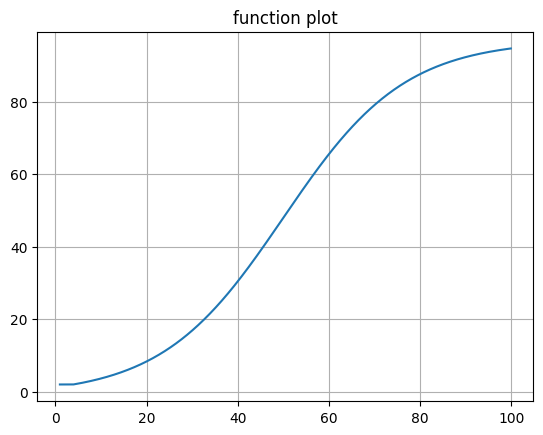

In [8]:
def calculate_k_size(x, k):
    """
    the function i make for the k size calculation is this sigmoid function
    f(x)=\ \left(k-2\right)\frac{1}{1+e^{-\frac{7.5}{k}\left(x-\frac{k}{2}\right)}}-2
    """
    b_term = np.divide(7.5, k)

    exponential_term = np.exp(-b_term*(x-k/2))
    sigmoid = np.divide(1, 1+exponential_term)

    y = (k-2)*sigmoid - 1
    # replace all values less than 2 with 2
    y = np.where(y < 2, 2, y)
    return y


# plot the sigmoid function for k = 100

x = np.arange(1, 100, 0.1)
y = calculate_k_size(x, 100)
# draw vertical line at y = 1
#plt.axhline(y=1, color='r', linestyle='-')
#plt.axvline(x=1, color='r', linestyle='-')

plt.grid()
plt.title("function plot")
plt.plot(x, y)

calculate_k_size(20, 20)

In [9]:
def genetic_programming(num_generations, population_size, max_depth, p_mutation, p_crossover, elite_percentage, variables_values, y_values, tournament_size, use_variable_tournament=True, silent_run=False):

    num_variables = len(variables_values[0])
    #print("Number of variables: ", num_variables)

    # Create the grammar
    genotype_list, grammar = create_n_genotypes(population_size, max_depth, num_variables)
    used_grammar = grammar
    # Initialize the genotypes
    current_genotypes = genotype_list

    # Define the statistics array to store the statistics for each generation
    stats_columns = len(index_to_variable_name)

    stats_shape = (num_generations, stats_columns)
    #print("Stats shape: ", stats_shape)
    stats = np.zeros(shape=stats_shape, dtype=np.float64)

    iterator_wrapper = tqdm(range(num_generations), desc="Generations") if not silent_run else range(num_generations)
    tournament_k_values = calculate_k_size(np.arange(1, num_generations+1, 1), num_generations)
    #print("Tournament k values: ", tournament_k_values)
    # Run the algorithm for the specified number of generations
    for generation in iterator_wrapper:
        if not silent_run:
            print(f"\n=== Generation {generation + 1} ===")
        if use_variable_tournament:
            current_tournament_size = tournament_k_values[generation]
            if not silent_run:
                print(f"Using variable tournament size: {current_tournament_size}")
        else : 
            current_tournament_size = tournament_size
        current_genotypes, current_stats = next_generation(current_genotypes, grammar, p_mutation, p_crossover, elite_percentage, variables_values, y_values, current_tournament_size, False)

        # Store the statistics for the current generation
        stats[generation, :] = current_stats

    return stats, current_genotypes, grammar

# read csv from inside synth1, called synth1-train.csv

df = pd.read_csv("synth1/synth1-train.csv", header=None)
display(df.head())

variable_matrix, y = parse_df(df)


run_stats, run_final_genotypes, used_grammar = genetic_programming(30, 50, 5, 0.2, 0.7, 0.2, variable_matrix, y, 10, True, False)


,0,1,2
0,-1.235929,-1.364106,6.515719
1,-0.602597,-0.607582,1.142835
2,2.804195,2.669195,40.677100
3,-0.226284,-2.977978,7.426363
4,2.040224,-0.592829,9.602611


Generations:   0%|          | 0/30 [00:00<?, ?it/s]


=== Generation 1 ===
Using variable tournament size: 2.0

=== Generation 2 ===
Using variable tournament size: 2.0

=== Generation 3 ===
Using variable tournament size: 2.0

=== Generation 4 ===
Using variable tournament size: 2.0

=== Generation 5 ===
Using variable tournament size: 2.0

=== Generation 6 ===
Using variable tournament size: 2.0

=== Generation 7 ===
Using variable tournament size: 2.337681816619291

=== Generation 8 ===
Using variable tournament size: 3.145321544887305

=== Generation 9 ===
Using variable tournament size: 4.107914666577978

=== Generation 10 ===
Using variable tournament size: 5.235603887108647

=== Generation 11 ===
Using variable tournament size: 6.5303597983598625

=== Generation 12 ===
Using variable tournament size: 7.982996423088997

=== Generation 13 ===
Using variable tournament size: 9.571138726348071

=== Generation 14 ===
Using variable tournament size: 11.259057975197654

=== Generation 15 ===
Using variable tournament size: 13.0

=== Gene

Versao com elitismo


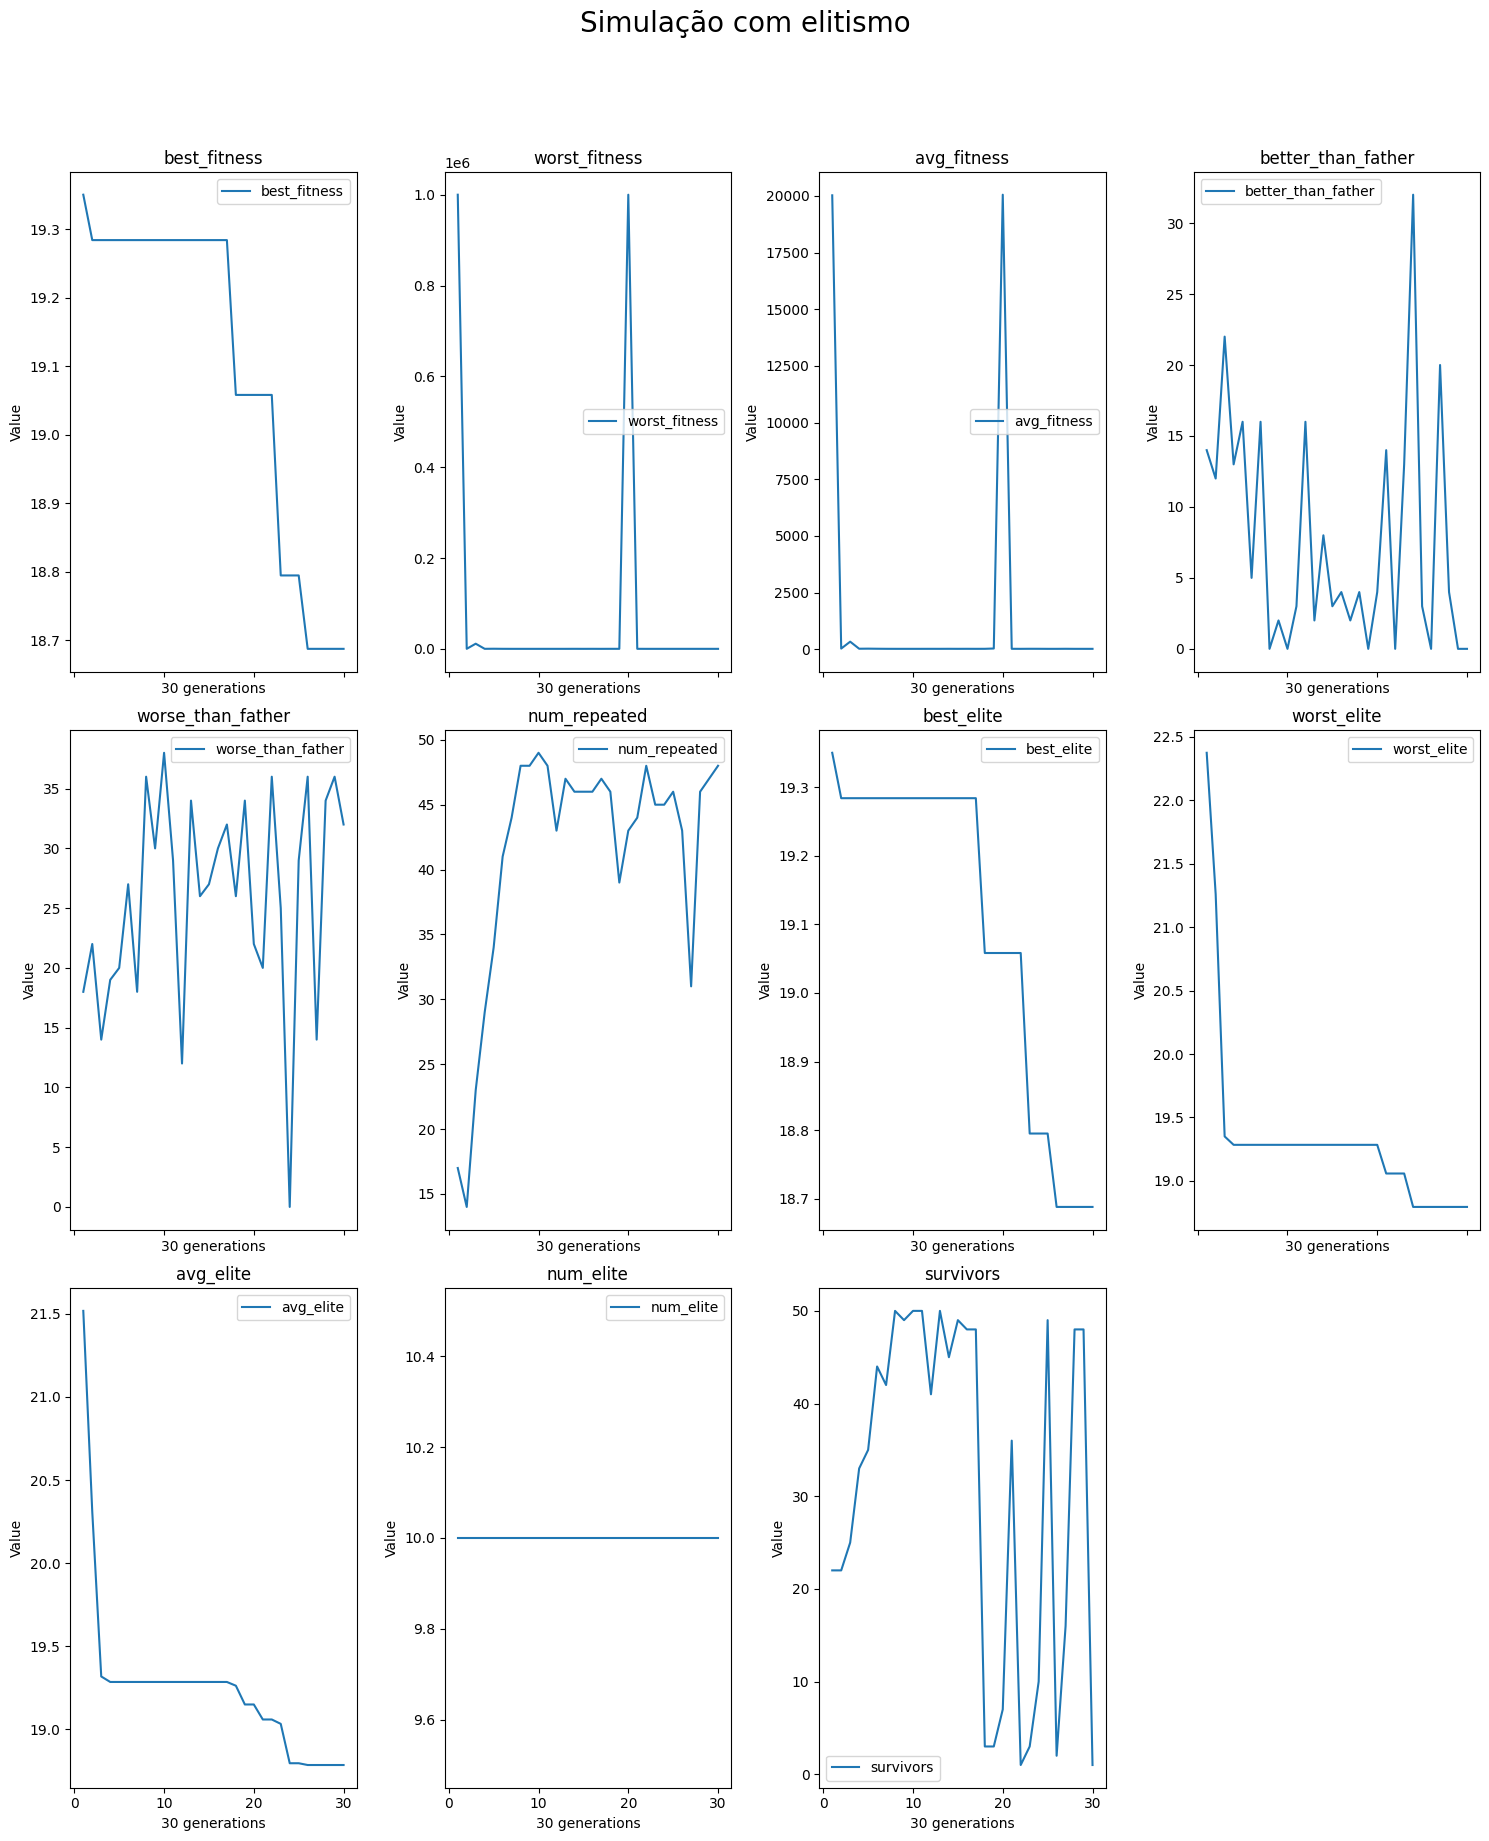

In [10]:
import math

def plot_stats(stats, index_to_variable_name, title=""):
    num_generations, num_stats = stats.shape

    num_cols = 4
    num_rows = math.ceil(num_stats / num_cols)

    # Create a subplot for each statistic in a mosaic grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows), sharex=True)
    axs = axs.flatten()  # Flatten the array to make it easier to work with

    # Plot the statistics on the corresponding subplot
    for i in range(num_stats):
        axs[i].plot(range(1, num_generations + 1), stats[:, i], label=index_to_variable_name[i])
        axs[i].set_title(index_to_variable_name[i])
        axs[i].set_xlabel(f"{num_generations} generations")
        axs[i].set_ylabel("Value")
        axs[i].legend()

    # If there are empty subplots, make them invisible
    for i in range(num_stats, len(axs)):
        axs[i].axis("off")

    # Adjust the layout of the subplots
    fig.tight_layout()
    
    if title == "":
        title = f"Run statistics for {num_generations} generations"
    fig.suptitle(title, fontsize=20, y=1.02)
    fig.subplots_adjust(top=0.93)
   
    plt.show()


run_parameters = {
    "generations": 200,
    "population_size": 25,
    "max_depth": 5,
    "p_mutation": 0.2,
    "p_crossover": 0.7,
    "elite_percentage": 0.1,
    "tournament_size": 2
}
data_save = (run_stats, run_stats, run_final_genotypes[0],run_stats[-1], used_grammar )
#cache = save_cache(cache, data_save, stats[0], "test", run_parameters)

print("Versao com elitismo")
plot_stats(run_stats, index_to_variable_name, "Simulação com elitismo")


Generations:   0%|          | 0/20 [00:00<?, ?it/s]


=== Generation 1 ===
Using variable tournament size: 2.0

=== Generation 2 ===
Using variable tournament size: 2.0

=== Generation 3 ===
Using variable tournament size: 2.0

=== Generation 4 ===
Using variable tournament size: 2.0

=== Generation 5 ===
Using variable tournament size: 2.0

=== Generation 6 ===
Using variable tournament size: 2.2836594285144143

=== Generation 7 ===
Using variable tournament size: 3.411530236382691

=== Generation 8 ===
Using variable tournament size: 4.7747834148429265

=== Generation 9 ===
Using variable tournament size: 6.332001200826745

=== Generation 10 ===
Using variable tournament size: 8.0

=== Generation 11 ===
Using variable tournament size: 9.667998799173255

=== Generation 12 ===
Using variable tournament size: 11.225216585157074

=== Generation 13 ===
Using variable tournament size: 12.588469763617308

=== Generation 14 ===
Using variable tournament size: 13.716340571485585

=== Generation 15 ===
Using variable tournament size: 14.60664367

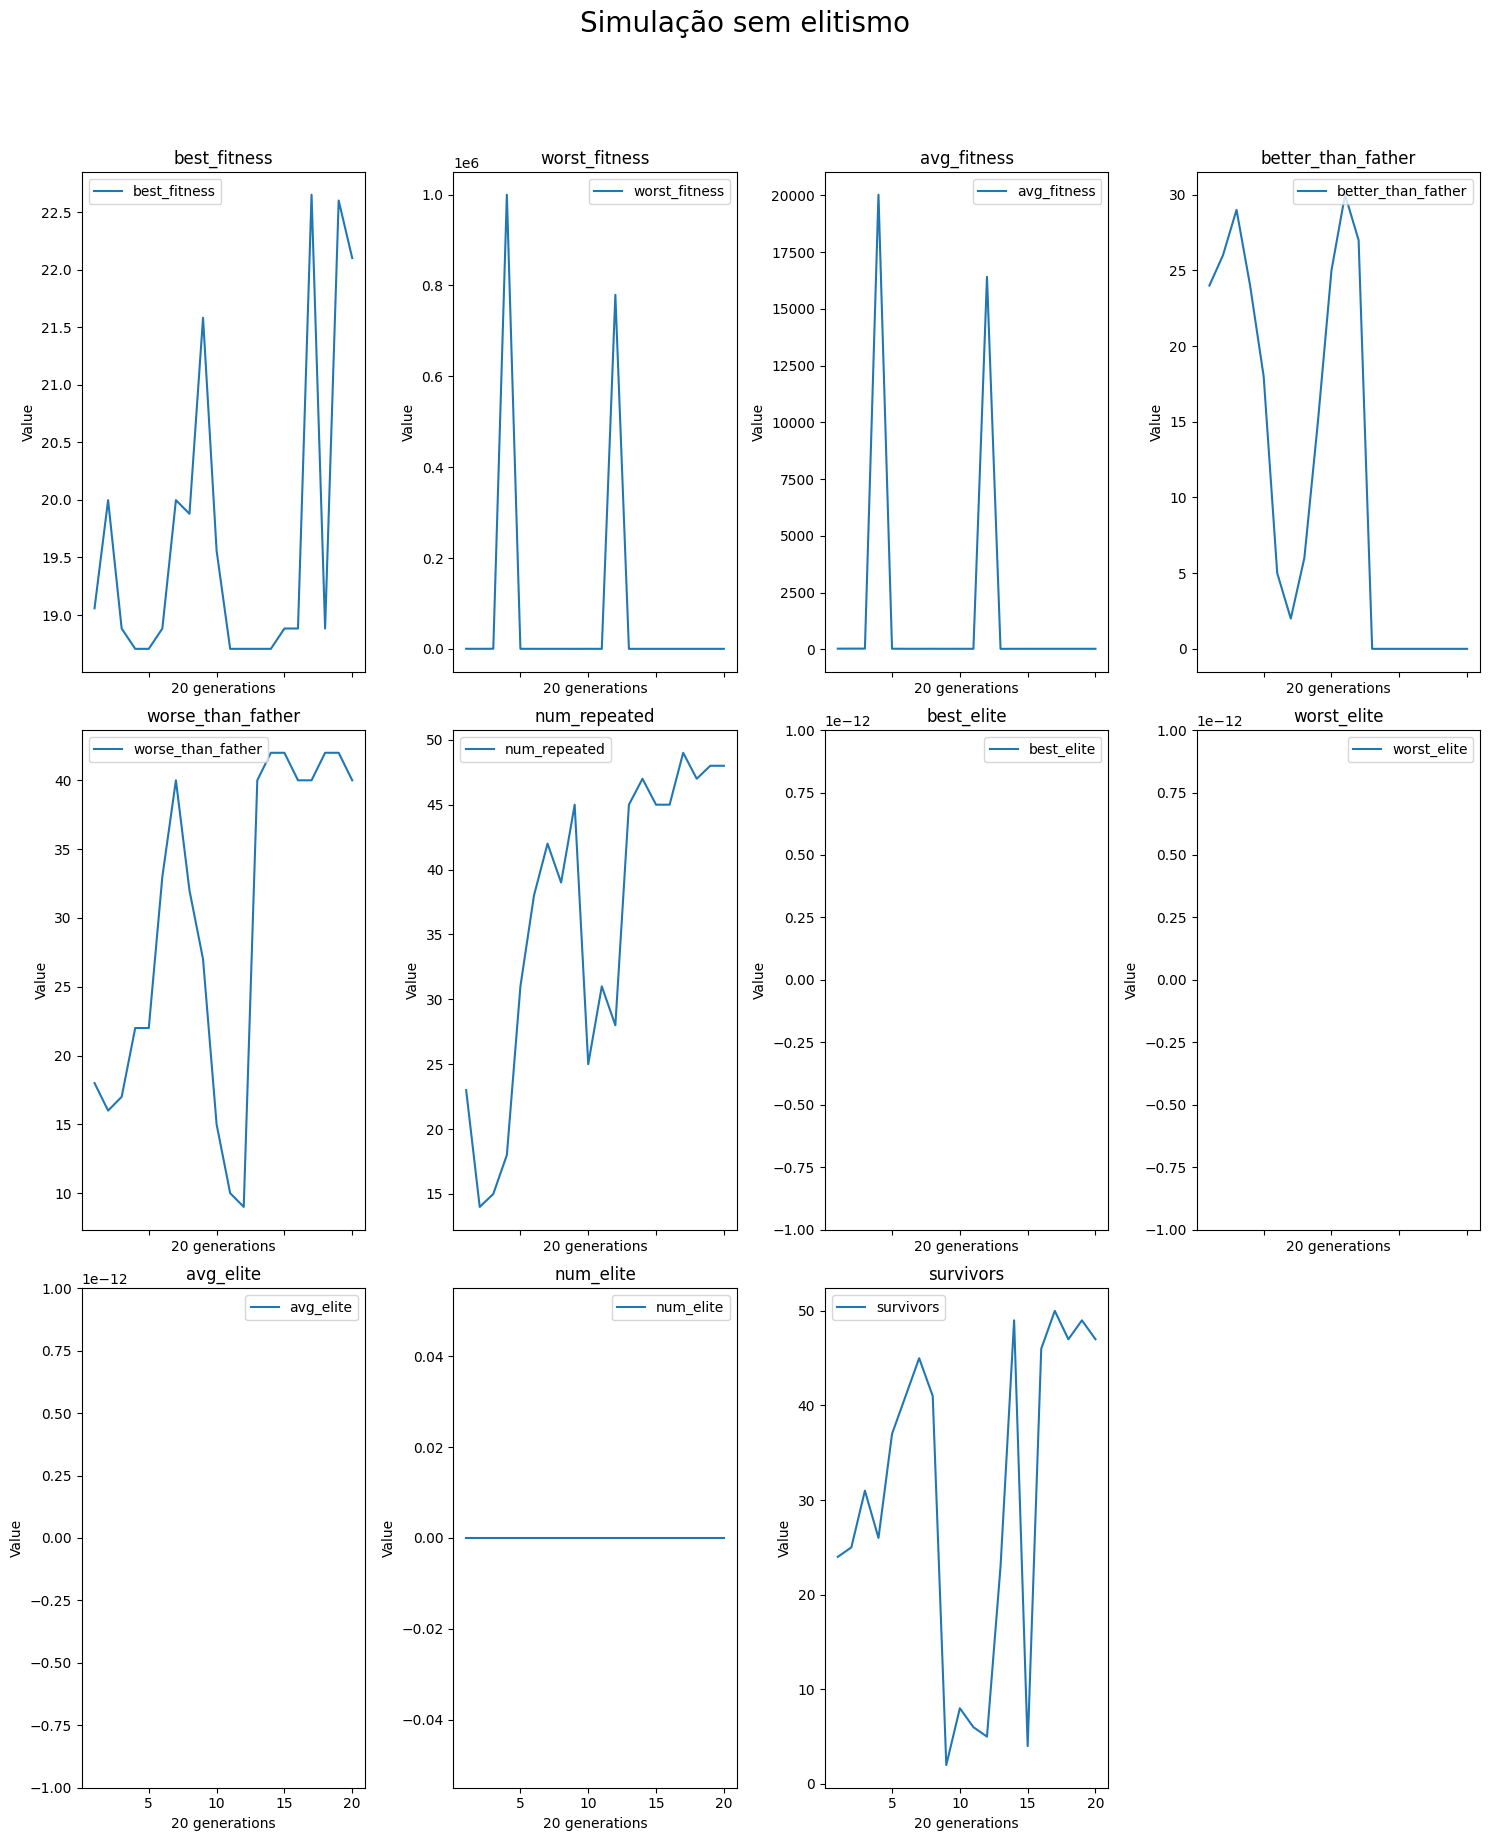

In [11]:
run_stats, run_final_genotypes, used_grammar = genetic_programming(20, 50, 5, 0.2, 0.7, 0, variable_matrix, y, 10)
plot_stats(run_stats, index_to_variable_name, "Simulação sem elitismo")

In [12]:
def plot_at_df_index(df, index, mean=False, std=False, title=""):
    row = df.iloc[index]
    if mean:
        stats_column = row["mean_stats"]
        display(row)
    else:
        stats_column = row["best_gen_stats"]
    stats_column = np.array(json.loads(stats_column))
    print(stats_column.shape)
    current_pop = row["population_size"]
    generations = row["generations"]
    p_mutation = row["p_mutation"]
    p_crossover = row["p_crossover"]
    std_last_gen = json.loads(row["std_last_gen"])
    final_fitness = row["final_fitness"]
    if title == "":
        title = f"{generations} generations, {current_pop} population, $p_m$ = {p_mutation} , $p_c$ = {p_crossover}"
    if std:
        rounded_std = round(std_last_gen[-1], 2)
        real_fitness = round(final_fitness, 2) + rounded_std
        title +="\nFitness: "+ str(real_fitness) + "$\pm$ " + str(rounded_std)

    plot_stats(stats_column, index_to_variable_name, title)

#plot_at_df_index(cache, 20, mean=False, std=True)

In [13]:
cache

,file,population_size,generations,final_fitness,final_std,p_mutation,p_crossover,elite_percentage,tournament_size,max_depth,mean_stats,best_gen_stats,stds,std_last_gen,grammar
0,synth1/synth1-train.csv,10,10,18.687799,1.746425,0.25,0.70,0.1,2,5,"[[20.44006582302118, 200037.17897324468, 20026...","[[18.93637949474958, 77.45278507077134, 32.770...","[[1.214963237546794, 399974.9954811889, 40000....","[0.3410312267574699, 17.246753421057957, 2.749...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
1,synth1/synth1-train.csv,10,10,18.705885,1.280625,0.25,0.70,0.1,2,5,"[[20.28857831244913, 318126.6531505309, 32026....","[[20.652567892658073, 88.7886837809459, 28.817...","[[1.1985521748782126, 416879.2693064003, 41998...","[0.46151829386664683, 225815.9196453599, 22581...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
2,synth1/synth1-train.csv,200,200,17.566617,13.626812,0.02,0.93,0.1,-1,5,"[[18.58425330302409, 2486224.592086305, 28768....","[[16.24880054160939, 13272284.008303907, 83742...","[[0.7845534813907105, 3713910.720711361, 24221...","[2.5739103747174106, 8.539353189350736, 2.7611...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
3,synth1/synth1-train.csv,200,200,15.879666,9.960422,0.07,0.88,0.1,-1,5,"[[18.481618683234217, 191531011.71914858, 9685...","[[16.24880054160939, 999995.0266455645, 20943....","[[0.7562028610791188, 545855146.3494654, 27277...","[4.136993193398287, 181638.23236139366, 4541.6...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
4,synth1/synth1-train.csv,200,200,11.349533,2.821347,0.12,0.83,0.1,-1,5,"[[18.800441623304103, 100007383403.90546, 5000...","[[18.882730588159433, 1587585.5962341686, 3204...","[[0.1251673186843814, 299997538977.9201, 14999...","[3.390113010586679, 181600.1832960449, 907.803...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
5,synth1/synth1-train.csv,200,200,7.832726,1.417745,0.22,0.73,0.1,-1,5,"[[18.234820898732814, 99996198398.49844, 49999...","[[18.705885448198348, 999915500414.6272, 49995...","[[1.6894856646571916, 299973100785.04755, 1499...","[2.236922359785112, 353035.70850160805, 1763.6...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
6,synth1/synth1-train.csv,200,200,7.345792,2.240000,0.27,0.68,0.1,-1,5,"[[18.666576115739424, 7497820.508470595, 52131...","[[18.758882521329422, 605519.9329217768, 3068....","[[0.20247393461017968, 19835147.09364128, 1047...","[1.1890678997574864, 369384.88900448167, 1978....","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<var>""]..."
7,synth1/synth1-train.csv,200,200,7.075895,2.785251,0.32,0.63,0.1,-1,5,"[[18.786769042177188, 8165870.987073573, 59544...","[[18.68779902591702, 19999987.169088207, 12005...","[[0.14853247774399625, 7957185.252412161, 4291...","[2.785250586286318, 2597420.5522218426, 23978....","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
8,synth1/synth1-train.csv,200,200,8.585370,2.225168,0.37,0.58,0.1,-1,5,"[[18.825333854454108, 7629598.1488278285, 5333...","[[19.230944740564965, 45166352.00592045, 25277...","[[0.18040571710414055, 13248210.471119223, 730...","[2.225167850442852, 27103535.967896704, 134596...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."
9,synth1/synth1-train.csv,200,200,8.330854,1.601511,0.42,0.53,0.1,-1,5,"[[18.778216726389495, 5425309.55161875, 38234....","[[18.758882521329422, 999987.1692537661, 8818....","[[0.08981049040669473, 12844705.660416253, 673...","[1.601510954236871, 468662.3198028616, 28435.6...","{""<start>"": [[""<expr>""]], ""<expr>"": [[""<number..."


## Plot a cada variação de semente

Não uso mais mas deixei a função no código

In [14]:
def run_and_plot_every_iteration(max_depth=3, p_mutation=0.05, p_crossover=0.09, elite_percentage=0.1, variables_values=variable_matrix, y_values=y, tournament_size=10):

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    generations = 40
    population_size = 50
    random_iterations = 30

    best_fitness_experiment = 0
    best_fitness_value = 10000000
    base_seed = 0
    for i in tqdm(range(random_iterations), desc="Random iterations"):
            base_seed += 1
            seed(base_seed)
            np.random.seed(base_seed)

            stats, final_genotypes, used_grammar = genetic_programming(generations, population_size, max_depth, p_mutation, p_crossover, elite_percentage, variables_values, y_values, tournament_size)
            stats_list.append(stats)
            final_genotypes_list.append(final_genotypes)
            final_used_grammar = used_grammar

            # get the best fitness from the last generation
            best_fitness_current = stats[-1, 0]
            if best_fitness_current < best_fitness_value:
                best_fitness_value = best_fitness_current
                best_fitness_experiment = i
            print("Case: ", i, " best fitness: ", best_fitness_current)
            plot_stats(stats, index_to_variable_name)

    # get the run with the best fitness overall
    best_genotypes = final_genotypes_list[best_fitness_experiment]


    # get the best genotype from the final generation of the best experiment
    fitness_list = calculate_all_fitnesses(best_genotypes, variable_matrix, y, grammar, NODE_TYPE, GENOTYPE_TYPE)

    # get the index of the best genotype
    best_index = best_n_items(fitness_list, 1)

    best_genotype = final_genotypes[best_index[0]]

    # print the best genotype
    print("Final function: ")
    copied_best = deep_copy_genotype(best_genotype, GENOTYPE_TYPE.copy())
    create_full_tree_from_genome(copied_best, final_used_grammar, NODE_TYPE, True)

    best_stats = stats_list[best_fitness_experiment]

    plot_stats(best_stats, index_to_variable_name)
#run_and_collect_data(3, 0.05, 0.9, 0.1, variable_matrix, y, 10)


# Método principal de testes

Recebe um arquivo de treinamento, parâmetros de execução e uma semente base.
Com isso, é capaz de inferir a quantidade de variáveis, criar a gramática de acordo, e instanciar n gerações do problema.

Fiz uma versão normal e uma concorrente. A concorrente não teve melhora significativa contra a normal, então para economizar recursos uso apenas ela.

minha hipótese é que talvez se dê pelo Global Interpreter Lock do python e sua restrição de paralelismo entre diferentes instâncias do intepretador python.

Experiments with  10 generations and population size 10


Random iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Stds of the problem across generations
best_fitness: 0.5087537499105959
worst_fitness: 13.249066434256637
avg_fitness: 2.7762024498906235
better_than_father: 1.857417562100671
worse_than_father: 2.6248809496813377
num_repeated: 1.4000000000000001
best_elite: 0.5087537499105959
worst_elite: 0.5087537499105959
avg_elite: 0.5087537499105959
num_elite: 0.0
survivors: 3.32264954516723


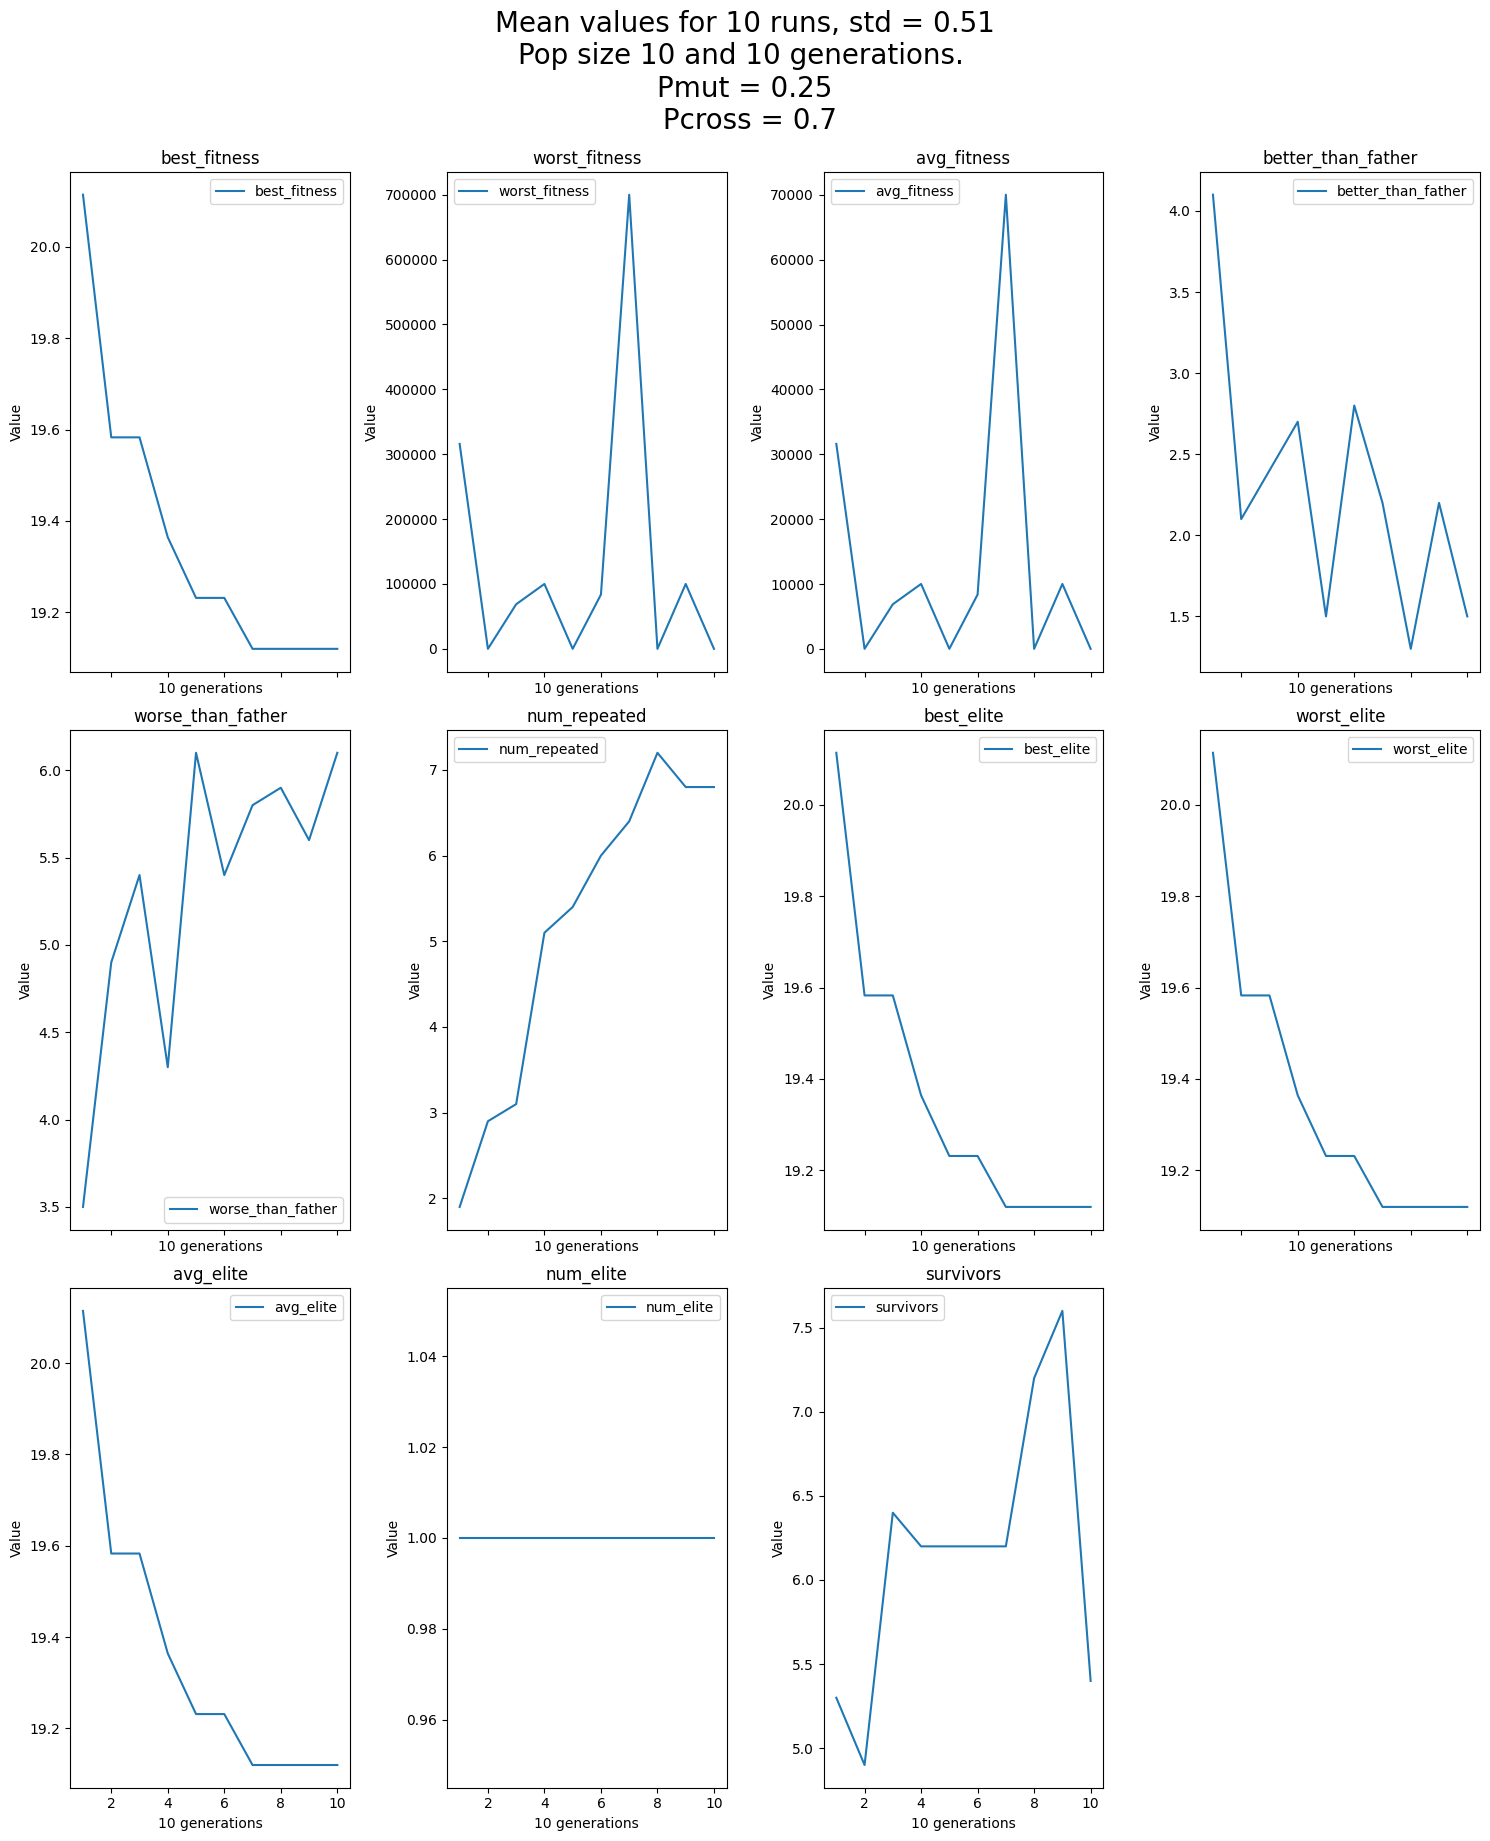

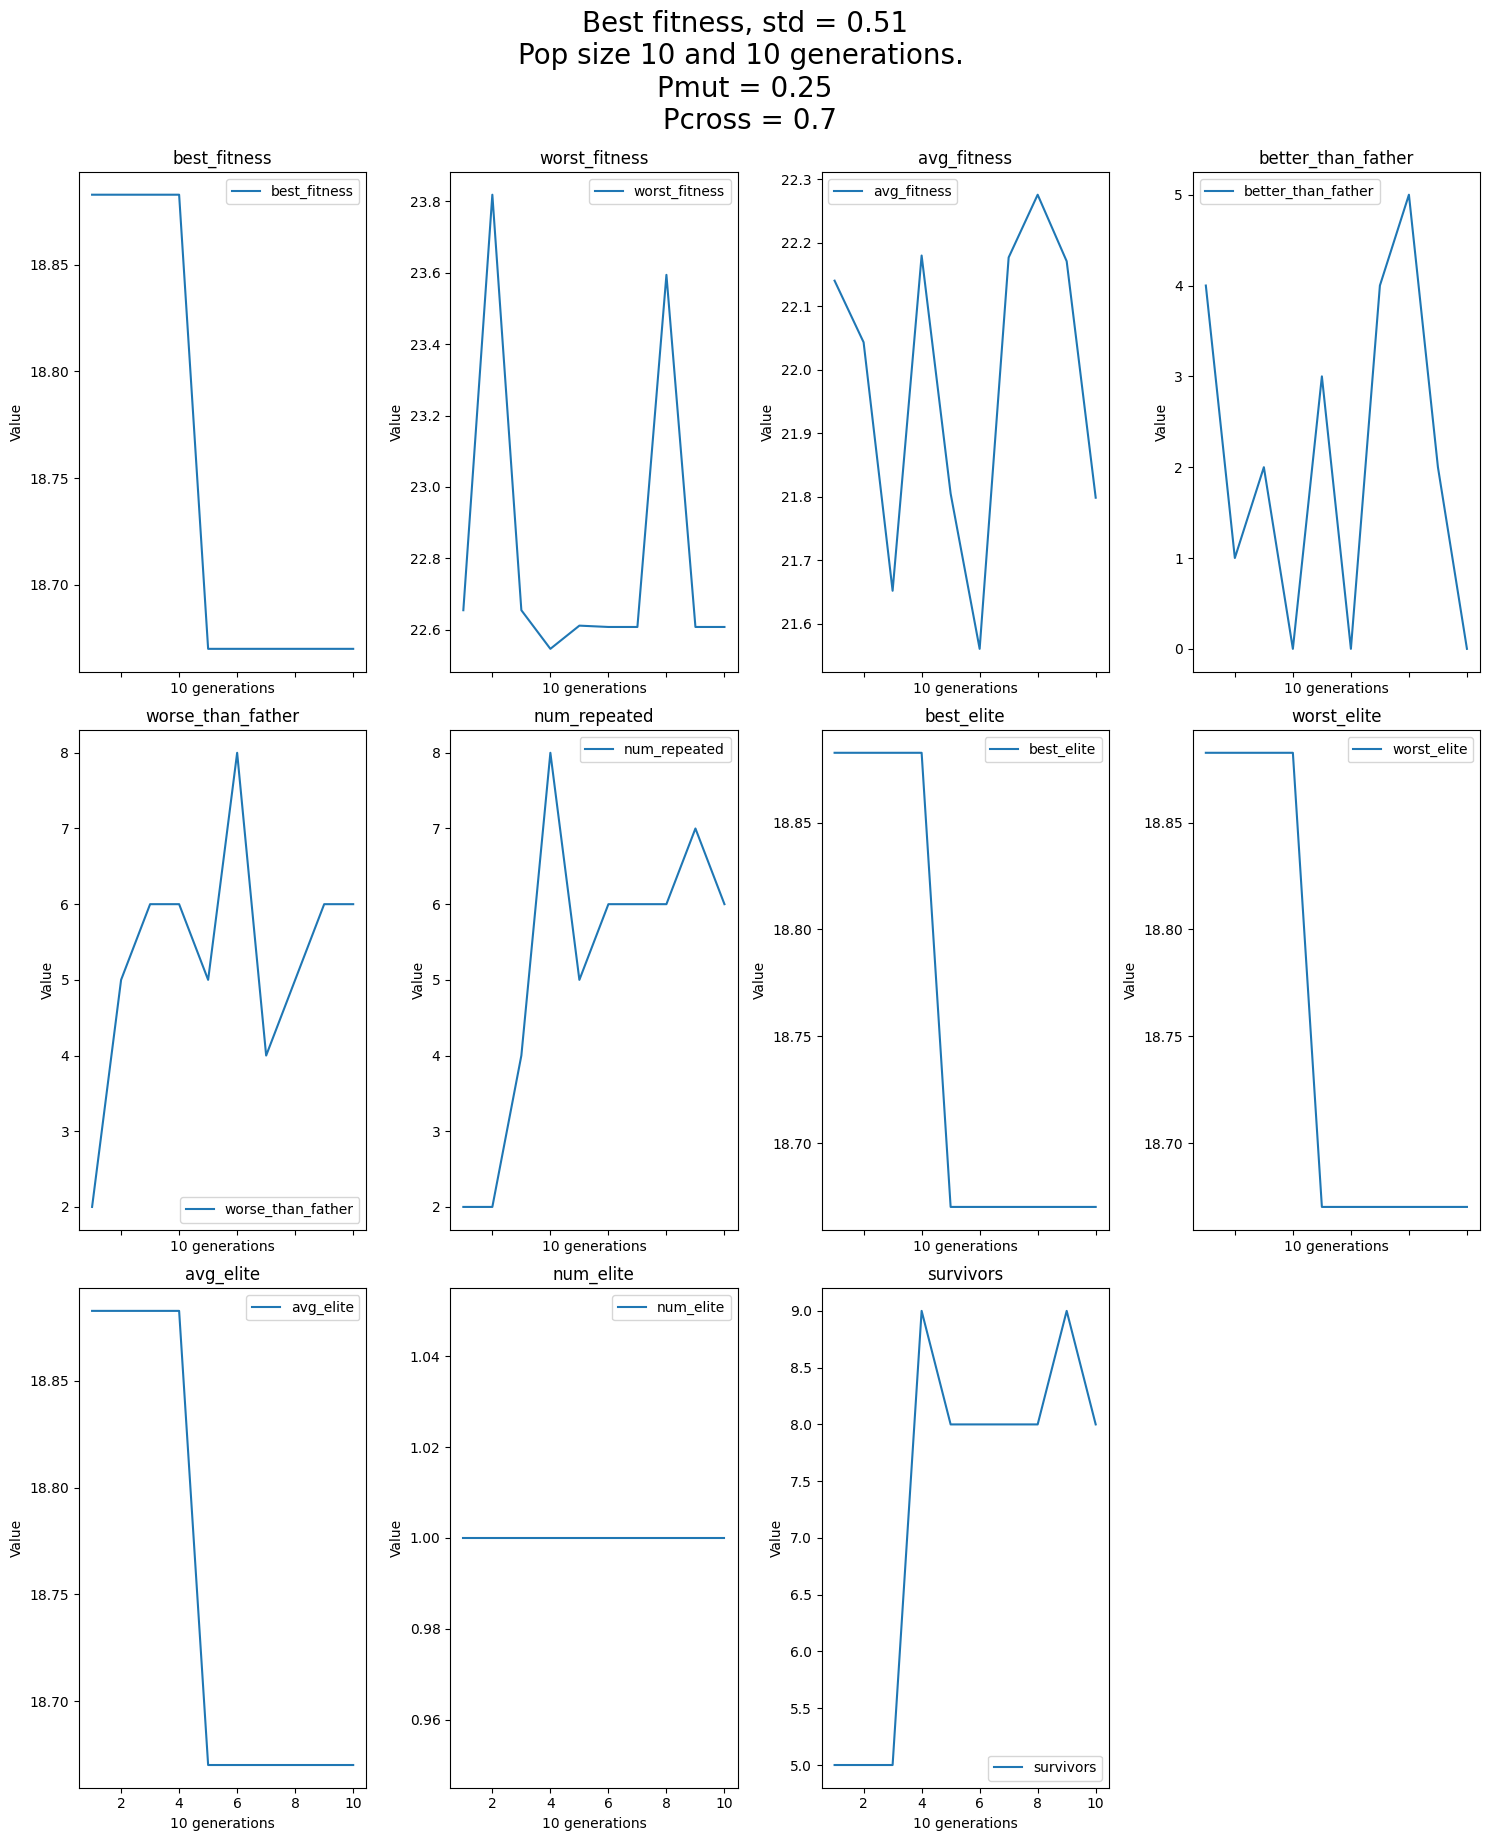

final fitness:  18.670082790847285
0.5087537499105959


In [15]:
def run_random_variations(train_filename, run_parameters, base_seed=0, change_tournament_size=True):
    df_train = pd.read_csv(train_filename, header=None)

    variable_matrix, y = parse_df(df_train)

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    print(f"Experiments with  {run_parameters['generations']} generations and population size {run_parameters['population_size']}")
    random_iterations = 10

    best_fitness_experiment = 0
    best_fitness_value = 10000000
    for i in tqdm(range(random_iterations), desc="Random iterations"):
        base_seed += 1
        seed(base_seed)
        np.random.seed(base_seed)

        run_stats, run_final_genotypes, used_grammar = genetic_programming(run_parameters['generations'], run_parameters['population_size'], run_parameters["max_depth"], run_parameters["p_mutation"], run_parameters["p_crossover"], run_parameters["elite_percentage"], variable_matrix, y, run_parameters["tournament_size"], change_tournament_size, True)
        stats_list.append(run_stats)
        final_genotypes_list.append(run_final_genotypes)
        final_used_grammar = used_grammar

        # get the best fitness from the last generation
        best_fitness_current = run_stats[-1, 0]
        if best_fitness_current < best_fitness_value:
            best_fitness_value = best_fitness_current
            best_fitness_experiment = i


    mean_stats = np.mean(stats_list, axis=0)

    stds_across_stats = np.std(stats_list, axis=0)
    std_final_gen = round(stds_across_stats[-1, 0], 2)
    print("Stds of the problem across generations")
    for i in range(len(index_to_variable_name)):
        print(f"{index_to_variable_name[i]}: {stds_across_stats[-1, i]}")


    title = f"Pop size {run_parameters['population_size']} and {run_parameters['generations']} generations. \nPmut = {run_parameters['p_mutation']}\n Pcross = {run_parameters['p_crossover']}"
    


    plot_stats(mean_stats, index_to_variable_name, f"Mean values for {random_iterations} runs, std = {std_final_gen}\n{title}")
    plot_stats(stats_list[best_fitness_experiment], index_to_variable_name, f"Best fitness, std = {std_final_gen}\n{title}")

    return mean_stats, stats_list[best_fitness_experiment],  final_genotypes_list[best_fitness_experiment], stds_across_stats, final_used_grammar

from multiprocessing import Pool


def run_iteration(i, base_seed, run_parameters, variable_matrix, y, change_tournament_size):
    base_seed = base_seed + i
    seed(base_seed)
    np.random.seed(base_seed)

    run_stats, run_final_genotypes, used_grammar = genetic_programming(run_parameters['generations'], run_parameters['population_size'], run_parameters["max_depth"], run_parameters["p_mutation"], run_parameters["p_crossover"], run_parameters["elite_percentage"], variable_matrix, y, run_parameters["tournament_size"], change_tournament_size, True)
    return run_stats, run_final_genotypes, used_grammar


# Não uso pq o speedup é minimo, não melhora muito o tempo de execução, q é em torno de 12minutos
# talvez se dê pelo problema com o Global Interpreter Lock do python
def run_random_variations_concurrent(train_filename, run_parameters, base_seed=0, change_tournament_size=True):
    df_train = pd.read_csv(train_filename, header=None)

    variable_matrix, y = parse_df(df_train)

    stats_list = []
    final_genotypes_list = []
    final_used_grammar = None

    print(f"Experiments with  {run_parameters['generations']} generations and population size {run_parameters['population_size']}")
    random_iterations = 10

    best_fitness_experiment = 0
    best_fitness_value = 10000000

    with Pool() as p:
        results = p.map(run_iteration, [(i, base_seed, run_parameters, variable_matrix, y, change_tournament_size) for i in range(random_iterations)])

    #results = []
    #for i in range(random_iterations):
    #    results.append(run_iteration(i, base_seed, run_parameters, variable_matrix, y, change_tournament_size))


    stats_list = [result[0] for result in results]
    final_genotypes_list = [result[1] for result in results]
    final_used_grammar = results[-1][2] 
    mean_stats = np.mean(stats_list, axis=0)

    stds_across_stats = np.std(stats_list, axis=0)

    print("Stds of the problem across generations")
    for i in range(len(index_to_variable_name)):
        print(f"{index_to_variable_name[i]}: {stds_across_stats[-1, i]}")

    # get the best fitness (oth index) from the last generation
    fitness_list = [stats[-1, 0] for stats in stats_list]
    for i, fitness in enumerate(fitness_list):
        if fitness < best_fitness_value:
            best_fitness_value = fitness
            best_fitness_experiment = i
    title = f"Pop size {run_parameters['population_size']} and {run_parameters['generations']} generations. \nPmut = {run_parameters['p_mutation']}\n Pcross = {run_parameters['p_crossover']}"
    
    plot_stats(mean_stats, index_to_variable_name, f"Mean values for {random_iterations} runs - {title}")
    plot_stats(stats_list[best_fitness_experiment], index_to_variable_name, f"Best fitness - {title}")

    return mean_stats, stats_list[best_fitness_experiment],  final_genotypes_list[best_fitness_experiment], stds_across_stats, final_used_grammar
        





run_parameters = {
    "generations": 10,
    "population_size": 10,
    "max_depth": 5,
    "p_mutation": 0.25,
    "p_crossover": 0.7,
    "elite_percentage": 0.1,
    "tournament_size": 2
}

agg, best_gen_stats, best_genotypes, stds, grammar = run_random_variations("synth1/synth1-train.csv", run_parameters, 0)

data_cache = (agg, best_gen_stats, best_genotypes, stds, grammar)
final_fitness = best_gen_stats[-1, 0]
print("final fitness: ", final_fitness)
final_std = stds[-1][0]
print(final_std)
#cache = save_cache(cache, data_cache, final_fitness, "synth1/synth1-train.csv", run_parameters)


Experiments for synth1/synth1-test.csv:   0%|          | 0/10 [00:00<?, ?it/s]

NEW PARAMETERS________________
pmut = 0.02, pcross = 0.9299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.07, pcross = 0.8799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.12, pcross = 0.83, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.17, pcross = 0.7799999999999999, elite = 0.1
Experiments with  200 generations and population size 200


Random iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Stds of the problem across generations
best_fitness: 1.5441741172540904
worst_fitness: 15337975.255874291
avg_fitness: 76622.72515684184
better_than_father: 14.256577429383253
worse_than_father: 13.858210562695316
num_repeated: 7.87146746166177
best_elite: 1.5441741172540904
worst_elite: 1.4713631421231004
avg_elite: 1.4748634680105954
num_elite: 0.0
survivors: 83.0


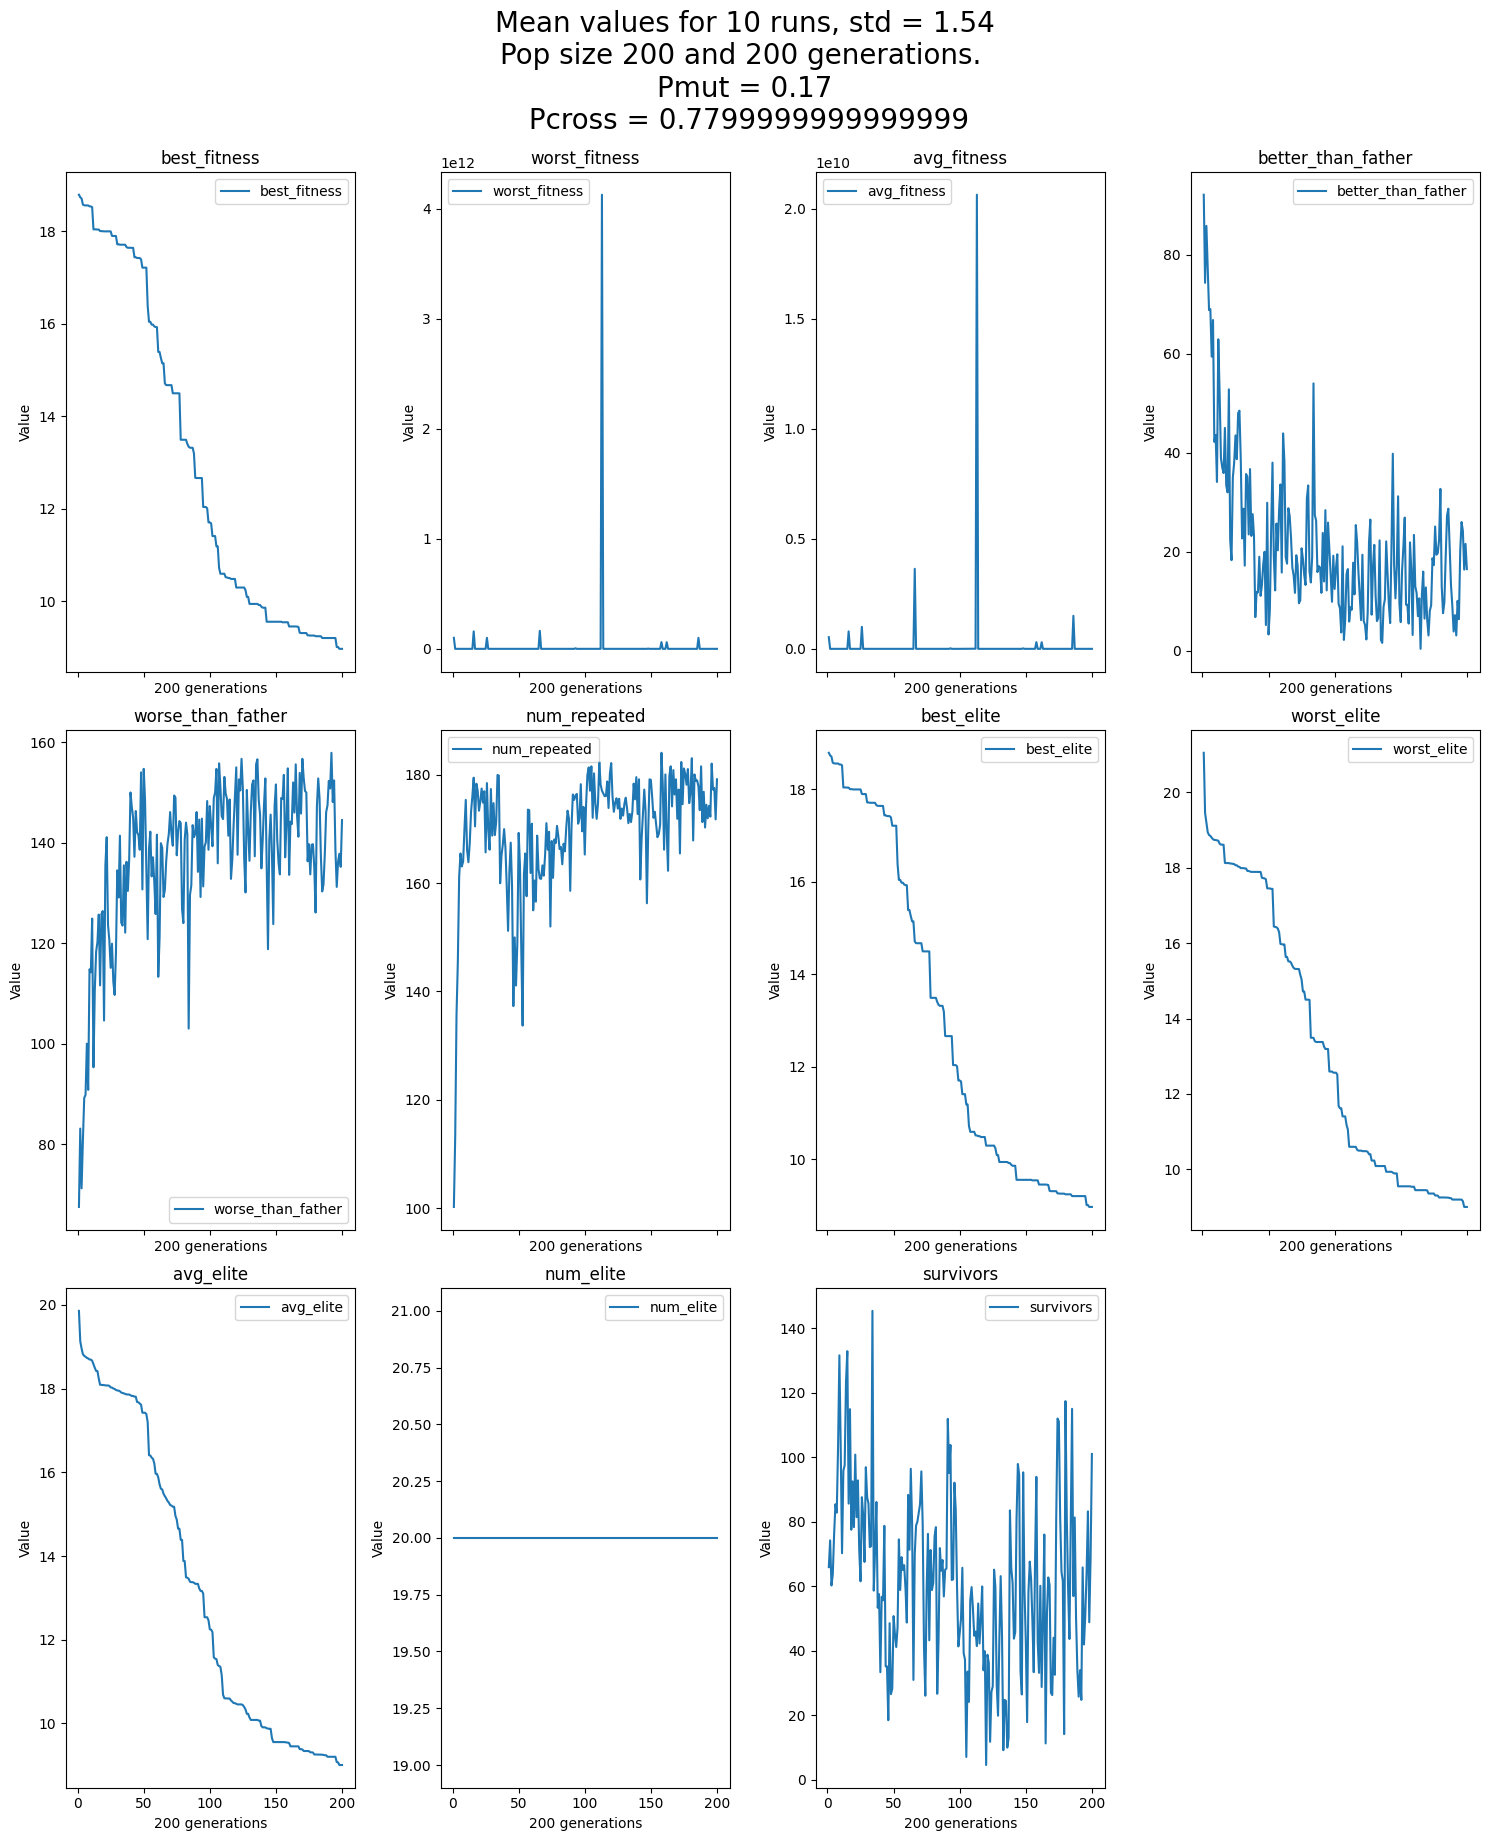

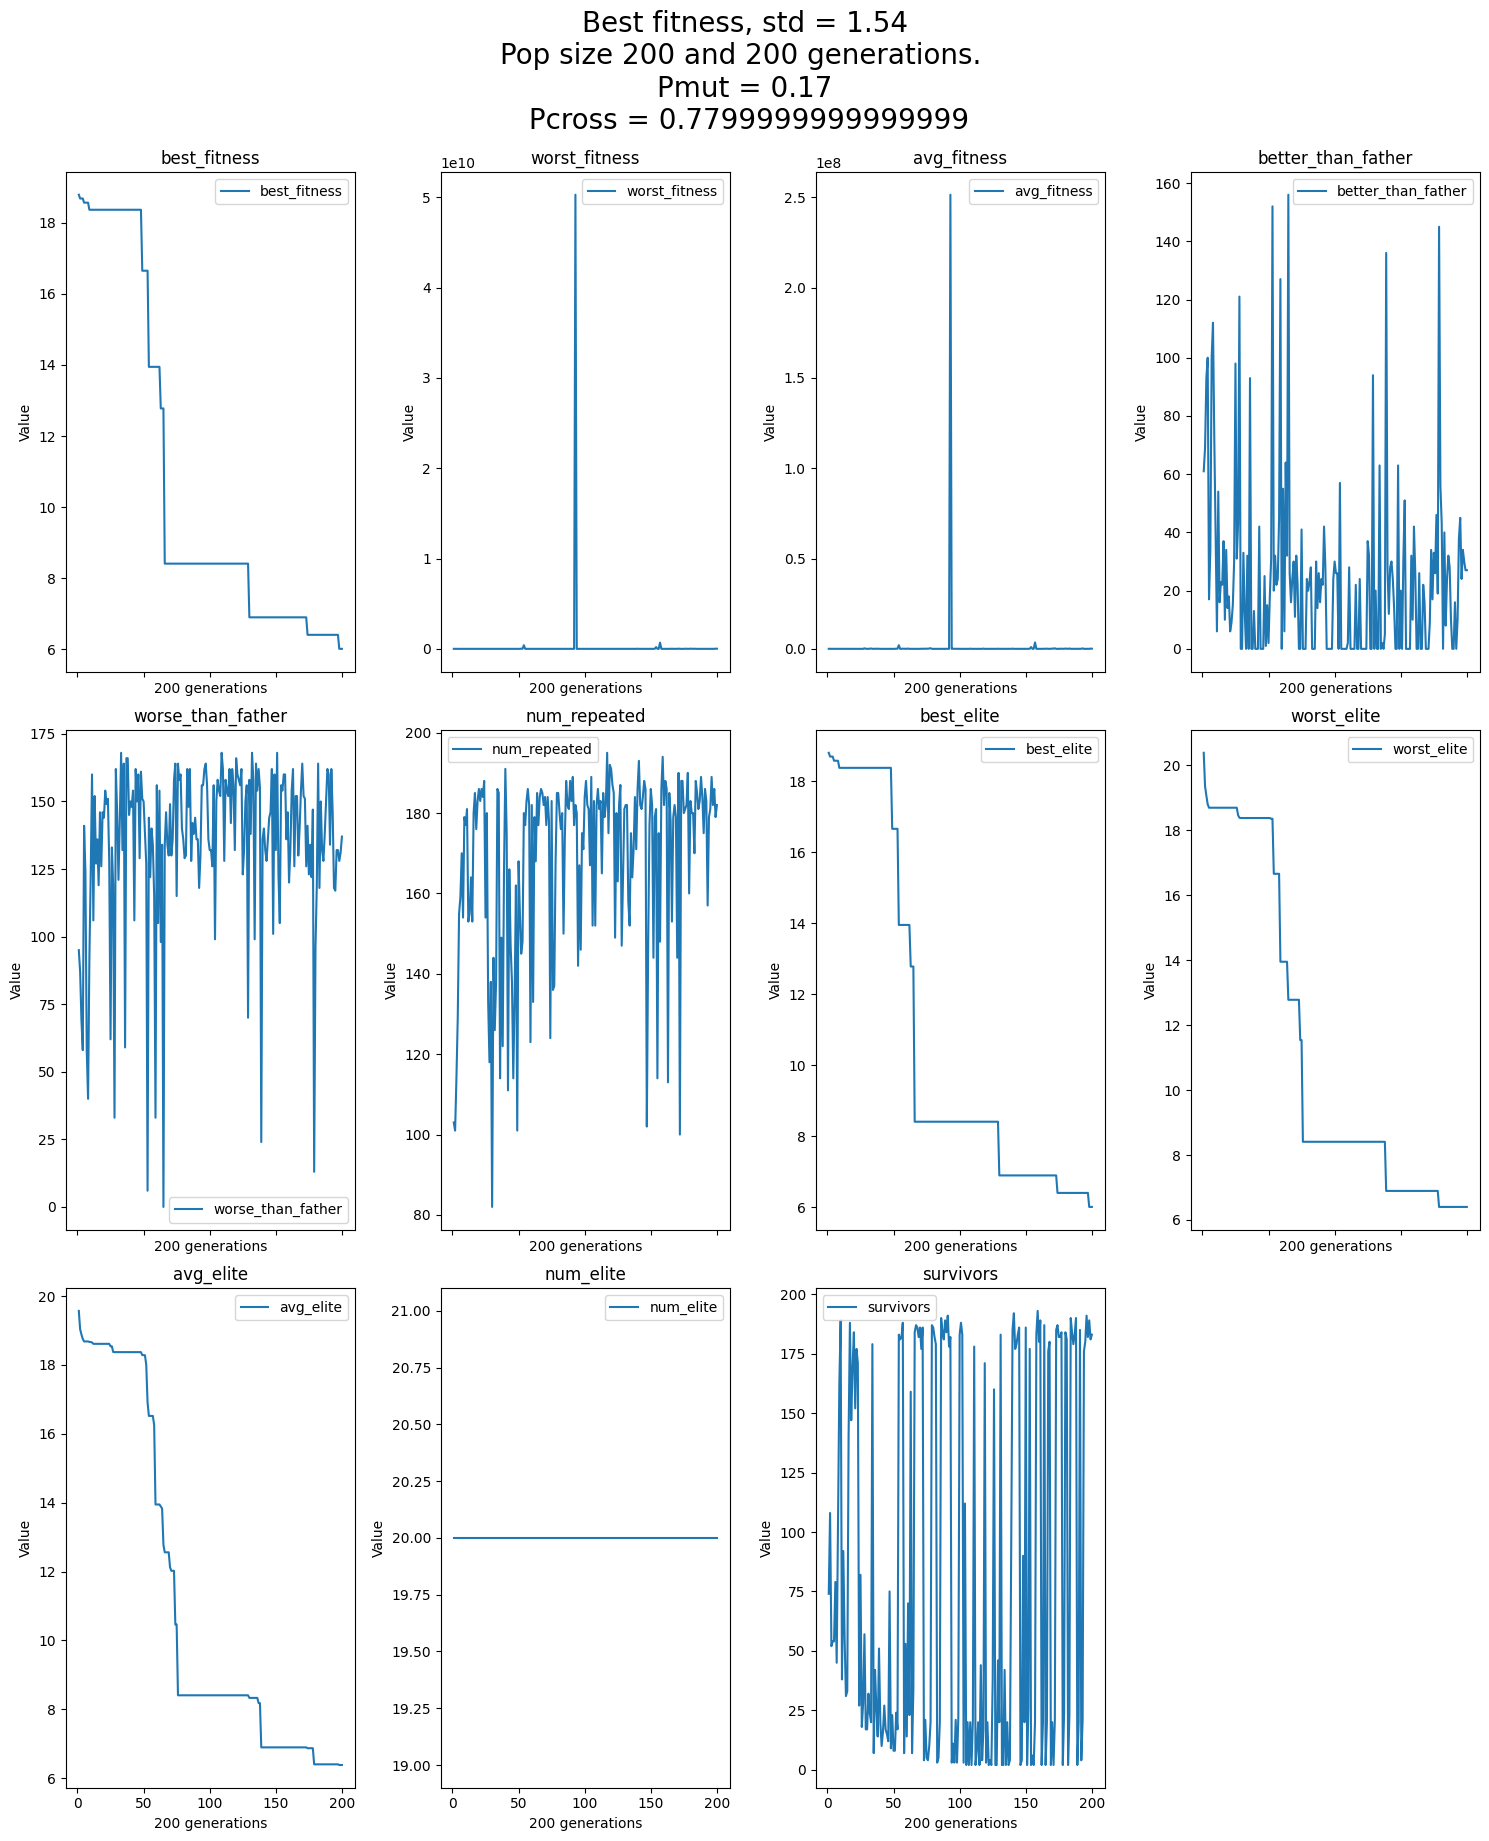

FINAL MEAN FITNESS:  8.967440206178718
Saving to cache!
NEW PARAMETERS________________
pmut = 0.22, pcross = 0.73, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.27, pcross = 0.6799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.32, pcross = 0.6299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.37, pcross = 0.58, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.42, pcross = 0.53, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.47, pcross = 0.48000000000000004, elite = 0.1
Loaded from cache
Found in cache! Skipping...


Experiments for synth2/synth2-test.csv:   0%|          | 0/10 [00:00<?, ?it/s]

NEW PARAMETERS________________
pmut = 0.02, pcross = 0.9299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.07, pcross = 0.8799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.12, pcross = 0.83, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.17, pcross = 0.7799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.22, pcross = 0.73, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.27, pcross = 0.6799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.32, pcross = 0.6299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.37, pcross = 0.58, elite = 0.1
Loaded from cache
Found in cache! Skippi

Experiments for concrete/concrete-test.csv:   0%|          | 0/10 [00:00<?, ?it/s]

NEW PARAMETERS________________
pmut = 0.02, pcross = 0.9299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.07, pcross = 0.8799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.12, pcross = 0.83, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.17, pcross = 0.7799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.22, pcross = 0.73, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.27, pcross = 0.6799999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.32, pcross = 0.6299999999999999, elite = 0.1
Loaded from cache
Found in cache! Skipping...
NEW PARAMETERS________________
pmut = 0.37, pcross = 0.58, elite = 0.1
Loaded from cache
Found in cache! Skippi

In [16]:
files = ["synth1/synth1-train.csv", "synth2/synth2-train.csv", "concrete/concrete-train.csv"]
test_files = ["synth1/synth1-test.csv", "synth2/synth2-test.csv", "concrete/concrete-test.csv"]


for i, file in enumerate(files):
    
    test_file = test_files[i]
 # variate mutation rate by 0.05, until 0.9
    for p_mut in tqdm(range(2, 50, 5), desc=f"Experiments for {test_file}"):
        
        mutation_rate = p_mut / 100
        crossover_rate = 1 - mutation_rate - 0.05
        run_parameters = {
            "generations": 200,
            "population_size": 200,
            "max_depth": 5,
            "p_mutation": mutation_rate,
            "p_crossover": crossover_rate,
            "elite_percentage": 0.1,
            "tournament_size": -1
        }
        print("NEW PARAMETERS________________")
        print(f"pmut = {run_parameters['p_mutation']}, pcross = {run_parameters['p_crossover']}, elite = {run_parameters['elite_percentage']}")

        returned_data = load_cache(cache, file, run_parameters)
        if returned_data is not None:
            print("Found in cache! Skipping...")
            mean_stats, best_gen_stats, stds, grammar  = returned_data
        else:
            mean_stats, best_gen_stats, best_genotypes, stds, grammar  = run_random_variations(file, run_parameters, 0, True)
            data_to_cache = (mean_stats, best_gen_stats, best_genotypes, stds, grammar)
            
            final_fitness = mean_stats[-1, 0]
            print("FINAL MEAN FITNESS: ", final_fitness)
            print("Saving to cache!")
            cache = save_cache(cache, data_to_cache, final_fitness, file, run_parameters)

# Upgrade 1: 
* Permitida taxa de reprodução
* Gramática simplificada com apenas operações básicas
* tamanho de lexicase variável

In [17]:
files = ["concrete/concrete-train.csv"]
test_files = ["concrete/concrete-test.csv"]


for i, file in enumerate(files):
    test_file = test_files[i]
    # variate mutation rate by 0.05, until 0.9
    for p_mut in tqdm(range(2, 50, 5), desc=f"Experiments for {test_file}"):
        
        mutation_rate = p_mut / 100
        crossover_rate = 1 - mutation_rate - 0.05
        run_parameters = {
            "generations": 500,
            "population_size": 500,
            "max_depth": 6,
            "p_mutation": mutation_rate,
            "p_crossover": crossover_rate,
            "elite_percentage": 0.1,
            "tournament_size": -1
        }
        print("NEW PARAMETERS________________")
        print(f"pmut = {run_parameters['p_mutation']}, pcross = {run_parameters['p_crossover']}, elite = {run_parameters['elite_percentage']}")

        returned_data = load_cache(cache, file, run_parameters)
        if returned_data is not None:
            print("Found in cache! Skipping...")
            mean_stats, best_gen_stats, stds, grammar  = returned_data
        else:
            mean_stats, best_gen_stats, best_genotypes, stds, grammar  = run_random_variations(file, run_parameters, 0, True)
            data_to_cache = (mean_stats, best_gen_stats, best_genotypes, stds, grammar)
            
            final_fitness = mean_stats[-1, 0]
            print("FINAL MEAN FITNESS: ", final_fitness)
            print("Saving to cache!")
            cache = save_cache(cache, data_to_cache, final_fitness, file, run_parameters)

In [21]:
def plot_test_fitness_per_genome(genotype_list, grammar, test_filename="synth1/synth1-train.csv"):
    df_test = pd.read_csv(test_filename, header=None)

    variable_matrix, y = parse_df(df_test)
    fitness_list = calculate_all_fitnesses(genotype_list, variable_matrix, y, grammar, NODE_TYPE, GENOTYPE_TYPE)

    print("Genotypes: ", len(genotype_list))
    for i, g in enumerate(genotypes):
        print(f"For the {i}th genotype, function is", sep=" ")
        copied_g = deep_copy_genotype(g, GENOTYPE_TYPE.copy())
        create_full_tree_from_genome(copied_g, grammar, NODE_TYPE, True)
    print(fitness_list)
    x_values = range(len(fitness_list))
    y_values = np.clip(fitness_list, None, 100)
    mean_value = np.mean(y_values)

    plt.bar(x_values, y_values, color='skyblue', edgecolor='black')
    plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')

    plt.xlabel('Genotype Index')
    plt.ylabel('Fitness')
    plt.title('Comparison with test case')
    plt.ylim(bottom=0)
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.show()

copy_best_genotypes = best_genotypes
print(grammar['<var>'])
plot_test_fitness_per_genome(copy_best_genotypes, grammar, "concrete/concrete-test.csv")

# Esse método não funcionou nessa run pq impedi execução da célula anterior, então a gramática está da synth1 invés da concrete
# porém ele funcionava comparando os genótipos e o dataset de teste e plottando um barplot da fitness

[['x'], ['y'], ['z'], ['{'], ['|'], ['}'], ['~'], ['\x7f']]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at c:\Users\diogo neiss\Downloads\Structured-Grammar-Evolution-in-Numba\scripts.py (1482)[0m
[1m
File "scripts.py", line 1482:[0m
[1mdef test_fitness():
    <source elided>

[1m@njit(parallel=True)
[0m[1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 3: [1mCannot determine Numba type of <class 'dict'>[0m 

This error may have been caused by the following argument(s):
- argument 3: [1mCannot determine Numba type of <class 'dict'>[0m 

This error may have been caused by the following argument(s):
- argument 3: [1mCannot determine Numba type of <class 'dict'>[0m 

This error may have been caused by the following argument(s):
- argument 3: [1mCannot determine Numba type of <class 'dict'>[0m
